# Task 4: Lightning Prediction with Density Map Approach

This notebook implements a density map prediction approach for lightning forecasting.
Instead of predicting discrete (t, x, y) coordinates, we predict a spatial-temporal probability map.

**Key Benefits:**
- Eliminates the assignment/ordering problem
- Naturally handles variable lightning counts
- Avoids regression-to-mean behavior
- Provides interpretable probability outputs

## Data Download

In [1]:
# Download the training dataset
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="benmoseley/ese-dl-2025-26-group-project", filename="train.h5", repo_type="dataset", local_dir="data")
hf_hub_download(repo_id="benmoseley/ese-dl-2025-26-group-project", filename="events.csv", repo_type="dataset", local_dir="data")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train.h5:   0%|          | 0.00/10.7G [00:00<?, ?B/s]

events.csv: 0.00B [00:00, ?B/s]

'data/events.csv'

## Imports

In [2]:
import pandas as pd
import h5py
import IPython
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import os
import io
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from scipy.ndimage import maximum_filter
from IPython.display import clear_output

## Data Loading Functions

In [21]:
# Load event metadata
df = pd.read_csv("data/events.csv", parse_dates=["start_utc"])
print(f"Total number of events: {len(df.id.unique())}")

Total number of events: 800


In [22]:
def load_event(id):
    """Load all image arrays for a given event id."""
    with h5py.File('data/train.h5', 'r') as f:
        event = {img_type: f[id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}
    return event

In [23]:
# Visualization helpers
def make_gif(outfile, files, fps=10, loop=0):
    """Helper function for saving GIFs."""
    imgs = [PIL.Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='gif', append_images=imgs[1:],
                 save_all=True, duration=int(1000/fps), loop=loop)
    im = IPython.display.Image(filename=outfile)
    im.reload()
    return im

def plot_event(id, output_gif=False, save_gif=False):
    """Helper function for plotting an event."""
    event = load_event(id)
    t = event["lght"][:, 0]

    def plot_frame(ti):
        f = (t >= ti*5*60 - 2.5*60) & (t < ti*5*60 + 2.5*60)
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        fig.suptitle(f"Event: {id}, Frame: {ti}, Time: {ti*5} min")
        axs[0].imshow(event["vis"][:, :, ti], vmin=0, vmax=10000, cmap="grey")
        axs[0].set_title('Visible')
        axs[1].imshow(event["ir069"][:, :, ti], vmin=-8000, vmax=-1000, cmap="viridis")
        axs[1].set_title('Infrared (Water Vapor)')
        axs[2].imshow(event["ir107"][:, :, ti], vmin=-7000, vmax=2000, cmap="inferno")
        axs[2].set_title('Infrared (Cloud/Surface Temperature)')
        axs[3].imshow(event["vil"][:, :, ti], vmin=0, vmax=255, cmap="turbo")
        axs[3].set_title('Radar (Vertically Integrated Liquid)')
        axs[3].scatter(event["lght"][f, 3], event["lght"][f, 4], marker="x", s=30, c="tab:red")
        axs[3].set_xlim(0, 384)
        axs[3].set_ylim(384, 0)
        if output_gif:
            file = f"_temp_{id}_{ti}.png"
            fig.savefig(file, bbox_inches="tight", dpi=150, pad_inches=0.02, facecolor="white")
            plt.close()
        else:
            plt.show()

    if output_gif:
        for ti in range(36):
            plot_frame(ti)
        im = make_gif(f"{id}.gif", [f"_temp_{id}_{ti}.png" for ti in range(36)])
        for ti in range(36):
            os.remove(f"_temp_{id}_{ti}.png")
        IPython.display.display(im)
        if not save_gif:
            os.remove(f"{id}.gif")
    else:
        plot_frame(0)
        plot_frame(17)
        plot_frame(34)

## Density Map Creation

Convert sparse lightning coordinates to dense probability maps using Gaussian kernels.

In [24]:
def create_density_map(lightning_events, height=192, width=192, num_frames=36, sigma=3.0):
    """
    Convert lightning (t, x, y) coordinates to density maps.

    Args:
        lightning_events: (N, 3) array of [time_seconds, x, y]
        height: Height of output density map
        width: Width of output density map
        num_frames: Number of temporal frames
        sigma: Gaussian kernel width (larger = more spread)

    Returns:
        density: (num_frames, height, width) array with values in [0, 1]
    """
    density = np.zeros((num_frames, height, width), dtype=np.float32)

    for i in range(len(lightning_events)):
        t_sec, x, y = lightning_events[i]
        frame_idx = int(t_sec / 300)  # 300 sec = 5 min per frame
        frame_idx = np.clip(frame_idx, 0, num_frames - 1)

        # Create Gaussian blob centered at (x, y)
        x_int, y_int = int(round(x)), int(round(y))

        # Only compute in local window for efficiency
        window = int(4 * sigma)
        x_min, x_max = max(0, x_int - window), min(width, x_int + window + 1)
        y_min, y_max = max(0, y_int - window), min(height, y_int + window + 1)

        if x_min >= x_max or y_min >= y_max:
            continue

        x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
        gaussian = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))

        density[frame_idx, y_min:y_max, x_min:x_max] += gaussian

    # Clip to [0, 1] (values can exceed 1 where strikes overlap)
    density = np.clip(density, 0, 1)

    return density

Density map shape: (36, 192, 192)
Value range: [0.000, 1.000]


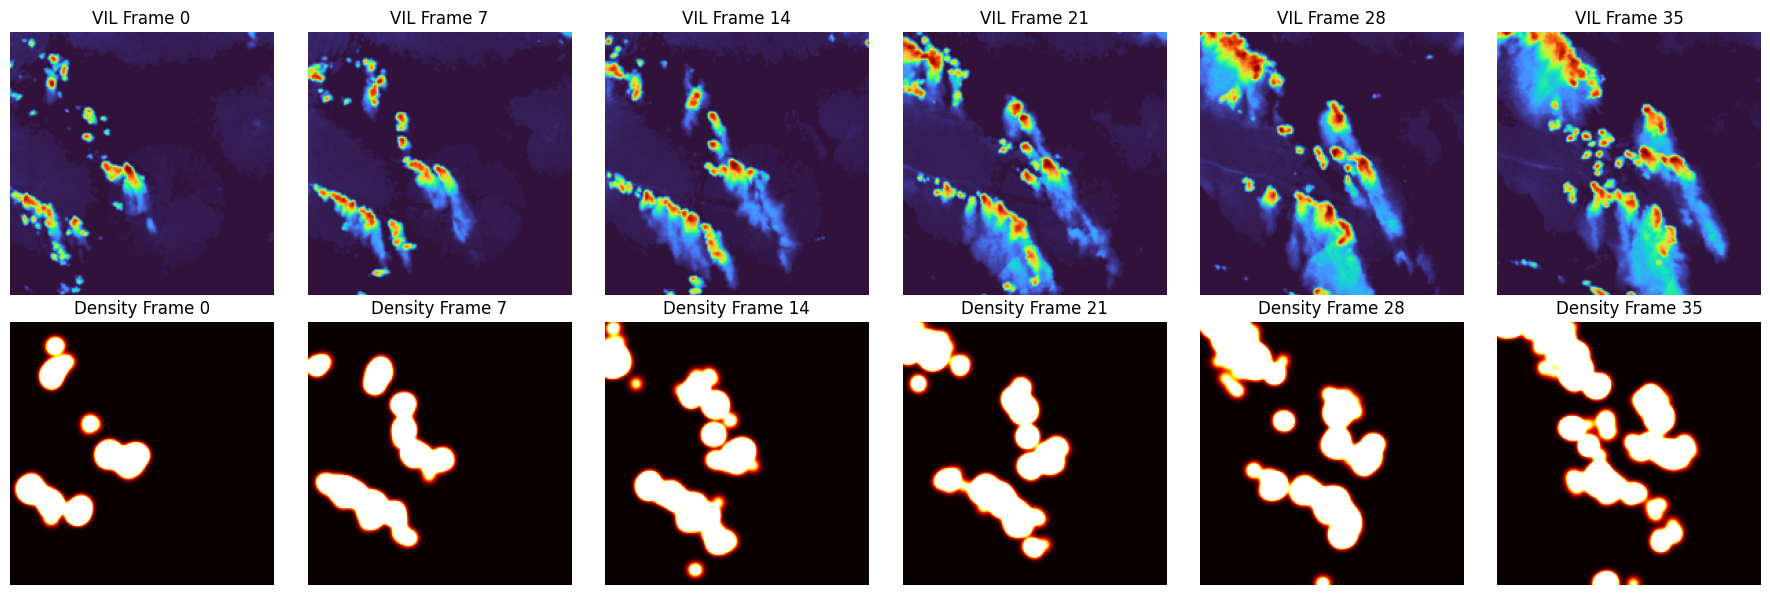

In [25]:
# Test density map creation on a sample event
sample_event = load_event("S778114")
lightning_coords = np.stack([
    sample_event['lght'][:, 0],           # time in seconds
    sample_event['lght'][:, 3] / 2.0,     # x scaled to 192
    sample_event['lght'][:, 4] / 2.0      # y scaled to 192
], axis=1).astype(np.float32)

density_map = create_density_map(lightning_coords, sigma=3.0)
print(f"Density map shape: {density_map.shape}")
print(f"Value range: [{density_map.min():.3f}, {density_map.max():.3f}]")

# Visualize a few frames
fig, axes = plt.subplots(2, 6, figsize=(18, 6))
frames_to_show = [0, 7, 14, 21, 28, 35]

for j, frame_idx in enumerate(frames_to_show):
    # Top row: VIL image (resized to 192x192)
    vil_resized = np.array(Image.fromarray(sample_event['vil'][:, :, frame_idx]).resize((192, 192), Image.BILINEAR))
    axes[0, j].imshow(vil_resized, vmin=0, vmax=255, cmap='turbo')
    axes[0, j].set_title(f'VIL Frame {frame_idx}')
    axes[0, j].axis('off')

    # Bottom row: Density map
    axes[1, j].imshow(density_map[frame_idx], cmap='hot', vmin=0, vmax=1)
    axes[1, j].set_title(f'Density Frame {frame_idx}')
    axes[1, j].axis('off')

plt.tight_layout()
plt.show()

## Dataset Creation with Density Maps

Uses PyTorch `Dataset` class for proper data loading:
- `StormDensityDataset`: Loads and preprocesses events on-the-fly from HDF5 file
- Creates Gaussian density maps from lightning coordinates
- Supports configurable sigma for density kernel width

In [26]:
class StormDensityDataset(Dataset):
    """
    PyTorch Dataset for storm prediction with density map targets.
    Loads and preprocesses storm events on-the-fly.

    Args:
        event_ids: List of event IDs to include in this dataset
        data_dir: Directory containing train.h5 and events.csv
        sigma: Gaussian kernel width for density maps
    """

    def __init__(self, event_ids, data_dir="data", sigma=3.0):
        self.event_ids = event_ids
        self.data_dir = data_dir
        self.h5_path = f"{data_dir}/train.h5"
        self.sigma = sigma

    def __len__(self):
        return len(self.event_ids)

    def __getitem__(self, idx):
        event_id = self.event_ids[idx]

        # Load event data
        with h5py.File(self.h5_path, 'r') as f:
            event = {img_type: f[event_id][img_type][:] for img_type in ['vis', 'ir069', 'ir107', 'vil', 'lght']}

        # Process images
        images = self._process_images(event)

        # Create density map
        density_map = self._create_density_map(event)

        return images, density_map, event_id

    def _process_images(self, event):
        """Resize and normalize image modalities."""
        # Initialize arrays for resized images (192x192)
        vis_resized = np.zeros((192, 192, 36), dtype=np.float32)
        vil_resized = np.zeros((192, 192, 36), dtype=np.float32)

        for i in range(36):
            vis_resized[:, :, i] = np.array(
                Image.fromarray(event['vis'][:, :, i]).resize((192, 192), Image.BILINEAR)
            )
            vil_resized[:, :, i] = np.array(
                Image.fromarray(event['vil'][:, :, i]).resize((192, 192), Image.BILINEAR)
            )

        ir069_data = event['ir069'].astype(np.float32)
        ir107_data = event['ir107'].astype(np.float32)

        # Permute to (frames, height, width)
        vis_permuted = np.transpose(vis_resized, (2, 0, 1))
        ir069_permuted = np.transpose(ir069_data, (2, 0, 1))
        ir107_permuted = np.transpose(ir107_data, (2, 0, 1))
        vil_permuted = np.transpose(vil_resized, (2, 0, 1))

        # Normalize each channel to ~[0, 1]
        vis_norm = vis_permuted / 10000.0
        ir069_norm = (ir069_permuted + 8000.0) / 7000.0
        ir107_norm = (ir107_permuted + 7000.0) / 9000.0
        vil_norm = vil_permuted / 255.0

        # Stack: (channels=4, frames=36, height=192, width=192)
        images = np.stack([vis_norm, ir069_norm, ir107_norm, vil_norm], axis=0).astype(np.float32)

        return images

    def _create_density_map(self, event):
        """Create density map from lightning coordinates."""
        # Scale coordinates from 384 to 192
        lightning_coords = np.stack([
            event['lght'][:, 0],           # time in seconds
            event['lght'][:, 3] / 2.0,     # x scaled to 192
            event['lght'][:, 4] / 2.0      # y scaled to 192
        ], axis=1).astype(np.float32)

        return create_density_map(lightning_coords, sigma=self.sigma)


def create_datasets(data_dir="data", test_size=0.2, val_size=0.1, subset_size=None, random_seed=42, sigma=3.0):
    """
    Create train/validation/test StormDensityDataset instances.

    Args:
        data_dir: Directory containing train.h5 and events.csv
        test_size: Fraction of data for test set
        val_size: Fraction of data for validation set
        subset_size: If provided, only use this many events (for debugging)
        random_seed: Random seed for reproducibility
        sigma: Gaussian kernel width for density maps

    Returns:
        train_dataset, val_dataset, test_dataset: StormDensityDataset instances
    """
    df = pd.read_csv(f"{data_dir}/events.csv")
    all_ids = df['id'].unique().tolist()

    if subset_size:
        random.seed(random_seed)
        all_ids = random.sample(all_ids, subset_size)

    # Split data
    train_val_ids, test_ids = train_test_split(all_ids, test_size=test_size, random_state=random_seed)
    val_size_adjusted = val_size / (1 - test_size)
    train_ids, val_ids = train_test_split(train_val_ids, test_size=val_size_adjusted, random_state=random_seed)

    # Create datasets
    train_dataset = StormDensityDataset(train_ids, data_dir, sigma=sigma)
    val_dataset = StormDensityDataset(val_ids, data_dir, sigma=sigma)
    test_dataset = StormDensityDataset(test_ids, data_dir, sigma=sigma)

    return train_dataset, val_dataset, test_dataset

In [27]:
def collate_fn_density(batch):
    """
    Collate function for density map targets.

    Args:
        batch: List of (images, density_map, event_id) tuples from StormDensityDataset

    Returns:
        images: (B, 4, 36, 192, 192) - stacked image tensors
        density_maps: (B, 36, 192, 192) - stacked density map tensors
        ids: tuple of event IDs
    """
    images, density_maps, ids = zip(*batch)

    images = torch.stack([torch.tensor(img) for img in images])
    density_maps = torch.stack([torch.tensor(dm) for dm in density_maps])

    return images, density_maps, ids


def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=4, num_workers=0):
    """
    Create DataLoaders from StormDensityDataset instances.

    Args:
        train_dataset: StormDensityDataset for training
        val_dataset: StormDensityDataset for validation
        test_dataset: StormDensityDataset for testing
        batch_size: Batch size for all loaders
        num_workers: Number of worker processes for data loading

    Returns:
        train_loader, val_loader, test_loader: DataLoader instances
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_density,
        num_workers=num_workers
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn_density,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        collate_fn=collate_fn_density,
        num_workers=num_workers
    )

    return train_loader, val_loader, test_loader

## Density Map Prediction Model

3D CNN encoder-decoder architecture that captures spatial-temporal patterns.

In [5]:
class DensityMapPredictor(nn.Module):
    def __init__(self, input_channels=4, num_frames=36):
        super().__init__()

        # Use 3D convolutions to capture spatial-temporal patterns
        self.encoder = nn.Sequential(
            # (B, 4, 36, 192, 192) -> (B, 32, 36, 96, 96)
            nn.Conv3d(input_channels, 32, kernel_size=(3, 5, 5), padding=(1, 2, 2)),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            # -> (B, 64, 36, 48, 48)
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            # -> (B, 128, 36, 24, 24)
            nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),

            # -> (B, 256, 36, 12, 12)
            nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2)),
        )

        self.decoder = nn.Sequential(
            # (B, 256, 36, 12, 12) -> (B, 128, 36, 24, 24)
            nn.ConvTranspose3d(256, 128, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),

            # -> (B, 64, 36, 48, 48)
            nn.ConvTranspose3d(128, 64, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(),

            # -> (B, 32, 36, 96, 96)
            nn.ConvTranspose3d(64, 32, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            # -> (B, 1, 36, 192, 192)
            nn.ConvTranspose3d(32, 1, kernel_size=(1, 4, 4), stride=(1, 2, 2), padding=(0, 1, 1)),
        )

    def forward(self, x):
        # x: (batch, channels, frames, H, W)
        features = self.encoder(x)
        density = self.decoder(features)
        return torch.sigmoid(density.squeeze(1))  # (batch, frames, H, W)

## Focal Loss

Critical for handling the extreme class imbalance (most pixels have no lightning).

In [6]:
def focal_loss(pred, target, alpha=0.25, gamma=2.0):
    """
    Focal loss for imbalanced binary classification.
    Down-weights easy negatives (empty pixels) to focus on hard cases.

    Args:
        pred: (B, T, H, W) predicted probabilities
        target: (B, T, H, W) ground truth density maps
        alpha: Weighting factor for positive class
        gamma: Focusing parameter (higher = more focus on hard examples)
    """
    # Clamp predictions to avoid log(0)
    pred = torch.clamp(pred, min=1e-7, max=1 - 1e-7)

    bce = F.binary_cross_entropy(pred, target, reduction='none')

    # pt = p if y=1, (1-p) if y=0
    pt = torch.where(target > 0.5, pred, 1 - pred)

    # Focal weight: (1 - pt)^gamma
    focal_weight = (1 - pt) ** gamma

    # Alpha weighting for positive/negative
    alpha_weight = torch.where(target > 0.5, alpha, 1 - alpha)

    loss = alpha_weight * focal_weight * bce
    return loss.mean()

## Create Dataset and Model

In [28]:
# Create datasets (adjust subset_size based on your compute resources)
train_dataset, val_dataset, test_dataset = create_datasets(subset_size=80, sigma=3.0)
train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset,
    batch_size=4
)

print(f"Number of training events: {len(train_dataset)}")
print(f"Number of validation events: {len(val_dataset)}")
print(f"Number of test events: {len(test_dataset)}")

# Check shapes
for images, density_maps, ids in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Density maps shape: {density_maps.shape}")
    break

Number of training events: 56
Number of validation events: 8
Number of test events: 16
Images shape: torch.Size([4, 4, 36, 192, 192])
Density maps shape: torch.Size([4, 36, 192, 192])


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
model = DensityMapPredictor(input_channels=4, num_frames=36).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Optimizer with learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

Using device: cuda
Model parameters: 1,861,569


## Training Loop

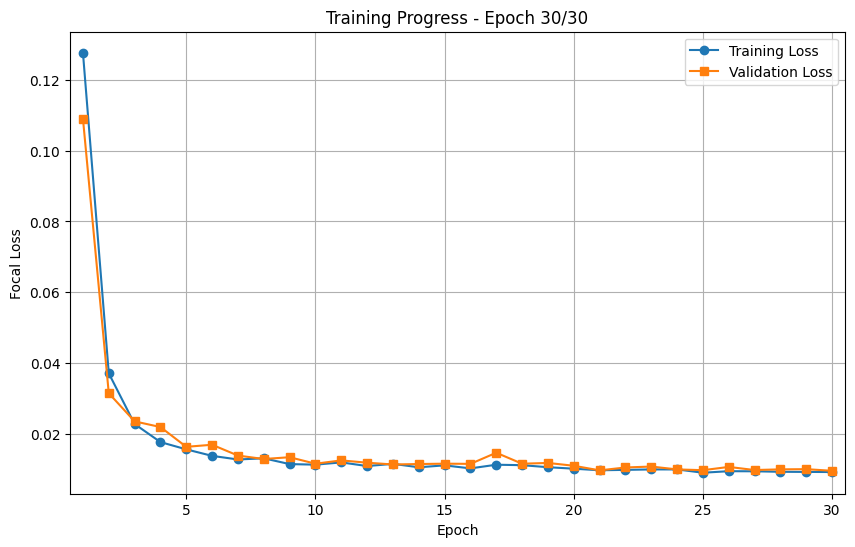

Epoch [30/30], Train Loss: 0.009213, Val Loss: 0.009562
Training complete.


In [14]:
num_epochs = 30
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0.0

    for batch_idx, (images, density_targets, ids) in enumerate(train_loader):
        images = images.to(device)
        density_targets = density_targets.to(device)

        optimizer.zero_grad()
        pred_density = model(images)

        loss = focal_loss(pred_density, density_targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, density_targets, ids in val_loader:
            images = images.to(device)
            density_targets = density_targets.to(device)

            pred_density = model(images)
            loss = focal_loss(pred_density, density_targets)
            total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Learning rate scheduling
    scheduler.step(epoch_val_loss)

    # Update plot after each epoch
    clear_output(wait=True)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epoch + 2), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, epoch + 2), val_losses, marker='s', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Focal Loss')
    plt.title(f'Training Progress - Epoch {epoch + 1}/{num_epochs}')
    plt.legend()
    plt.grid(True)
    plt.xlim(0.5, num_epochs + 0.5)
    plt.show()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

print("Training complete.")

## Visualization: Predicted vs Actual Density Maps

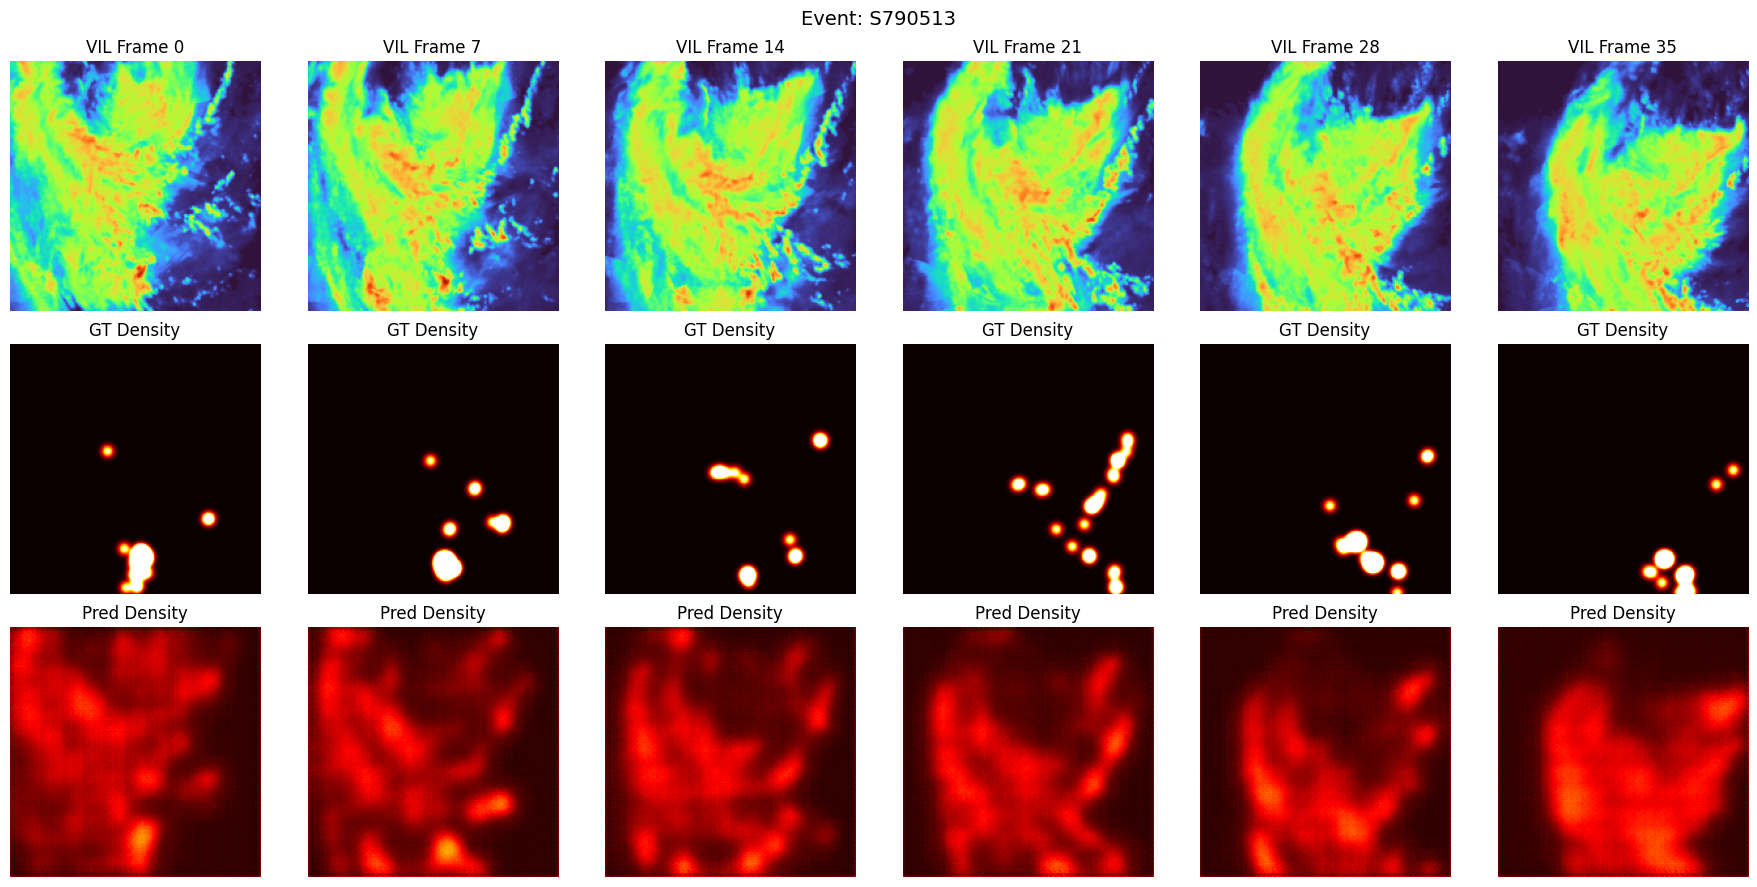

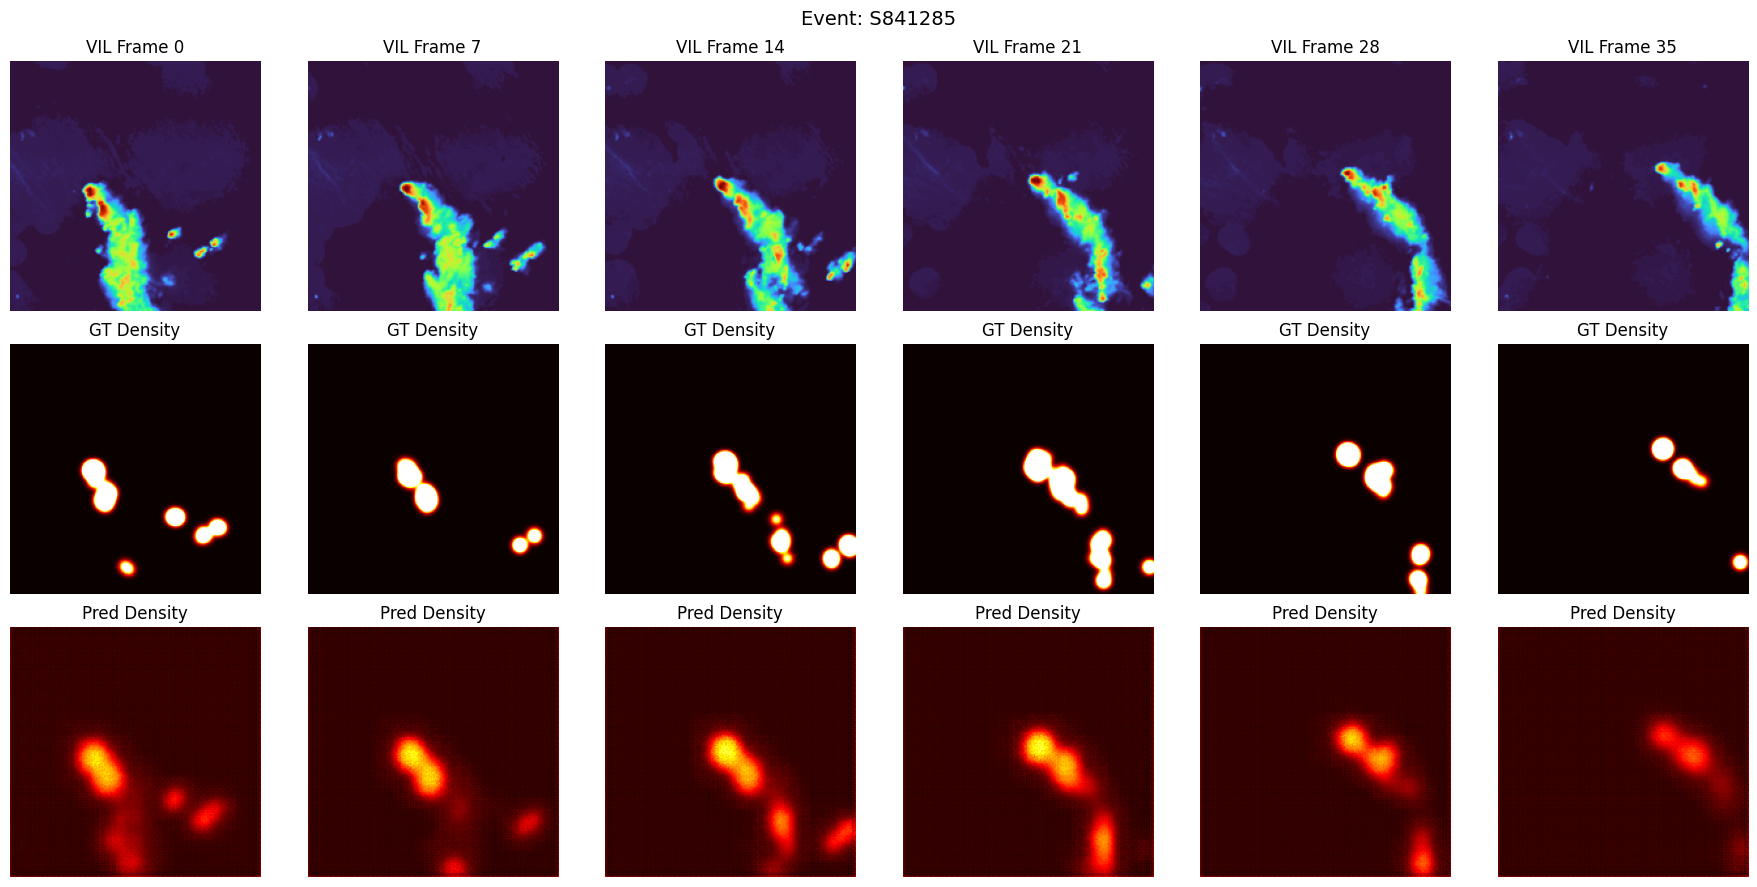

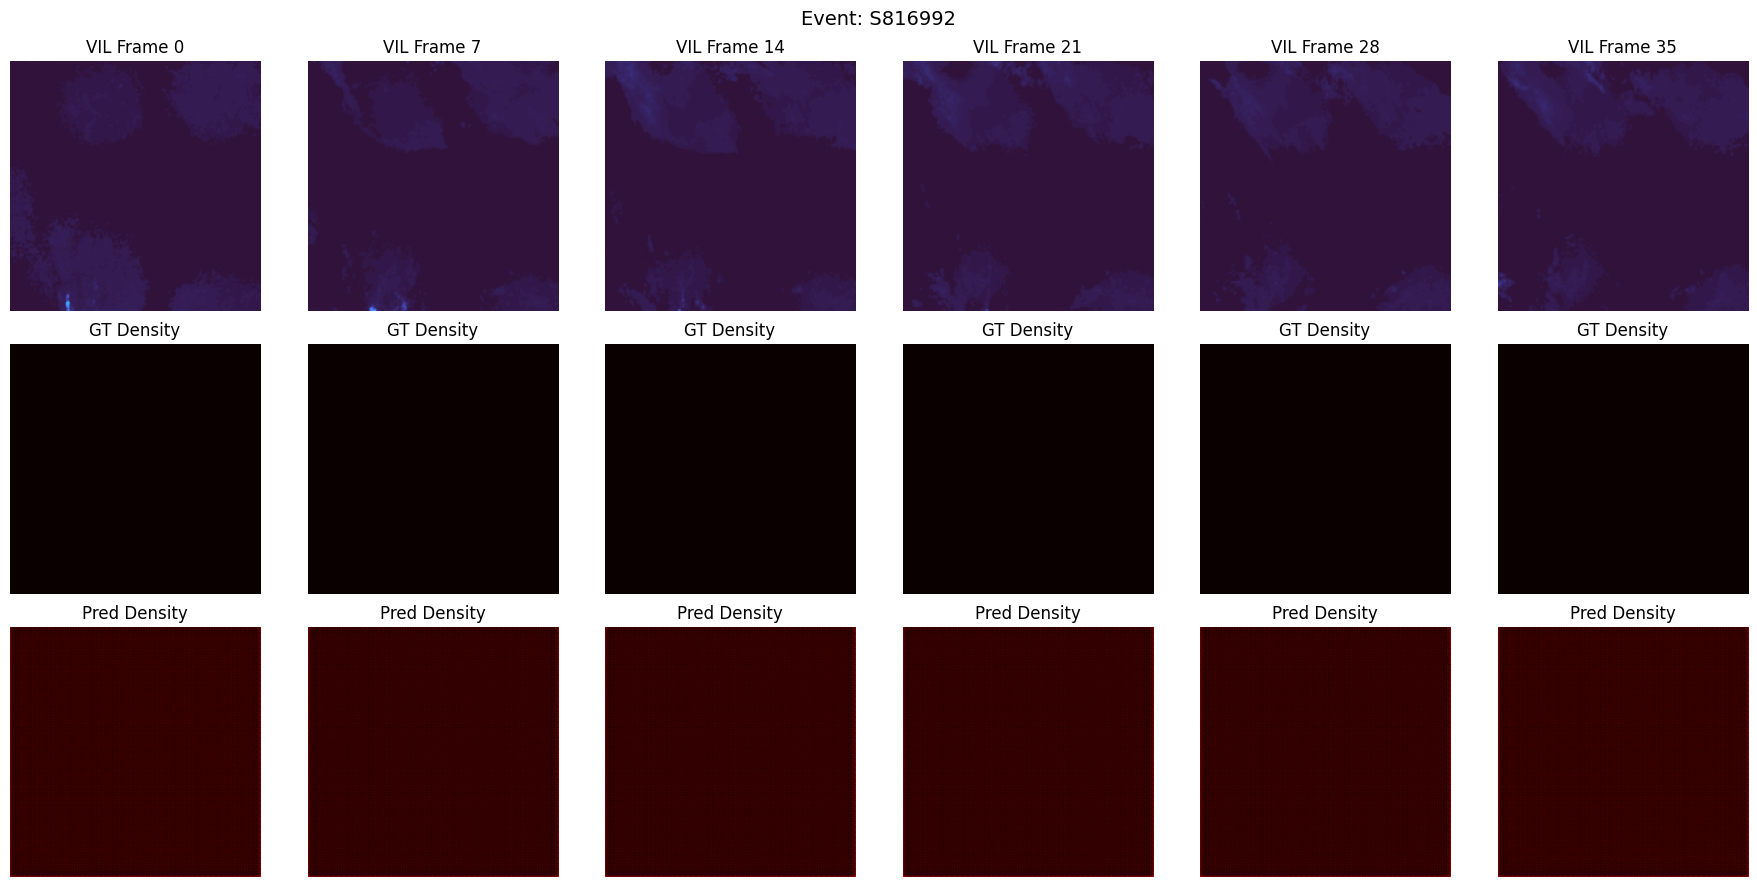

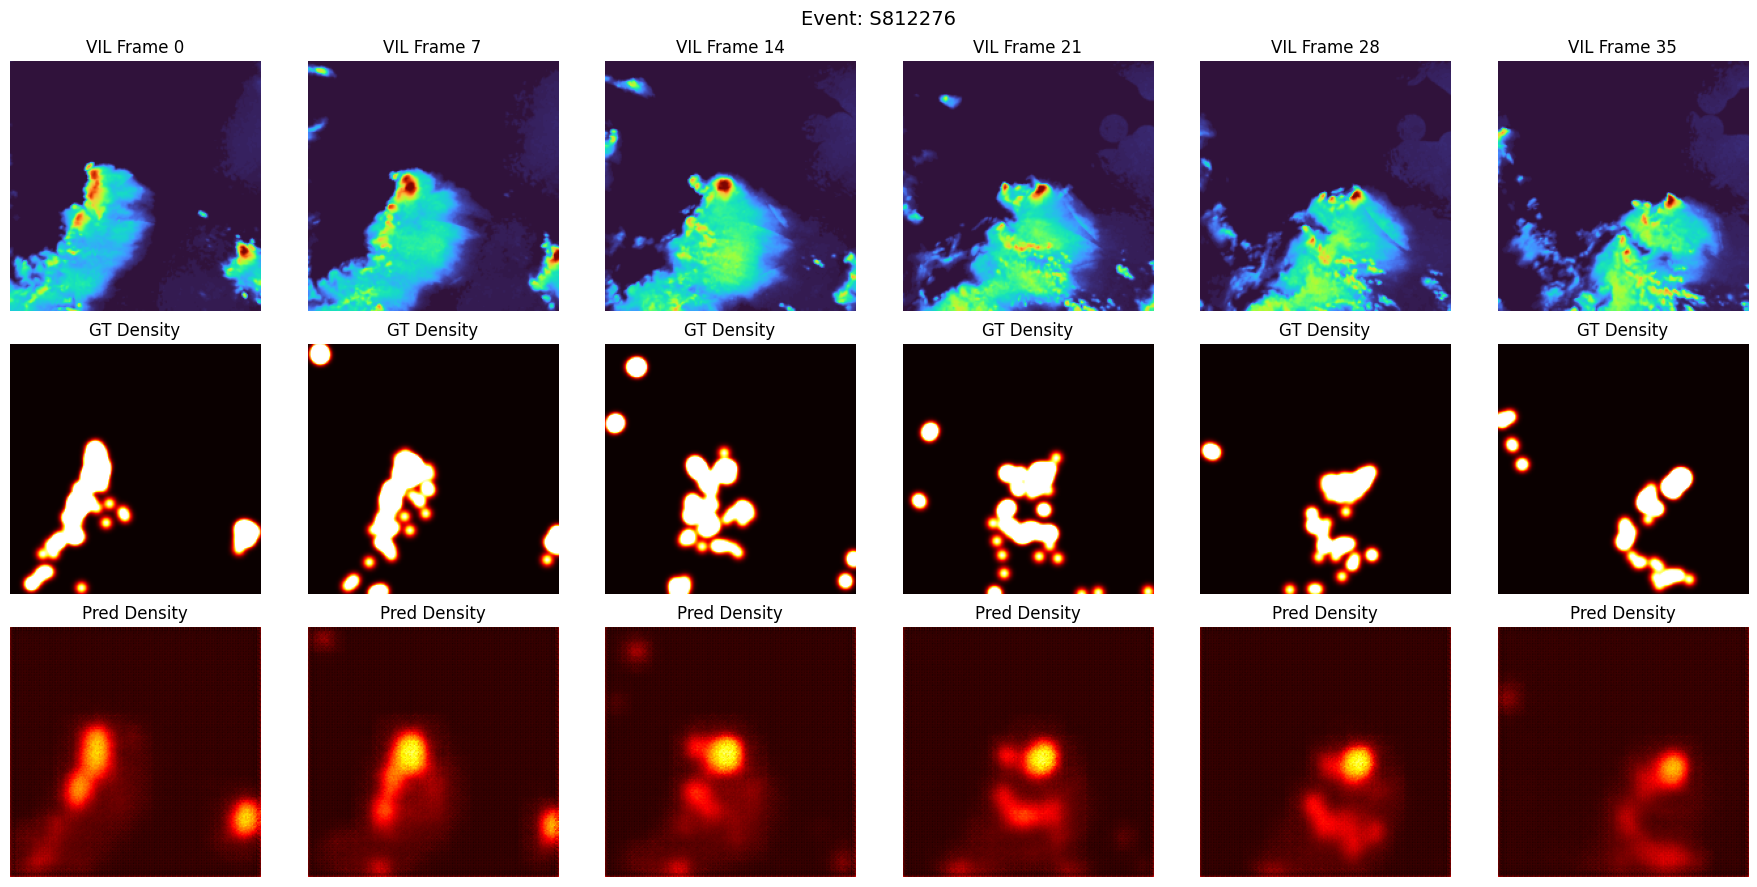

In [31]:
def visualize_density_prediction(model, test_loader, device, num_samples=4):
    """Visualize predicted vs actual density maps."""
    model.eval()

    with torch.no_grad():
        images, density_targets, ids = next(iter(test_loader))
        images = images.to(device)
        pred_density = model(images).cpu().numpy()
        density_targets = density_targets.numpy()

        for i in range(min(num_samples, len(ids))):
            fig, axes = plt.subplots(3, 6, figsize=(18, 9))
            fig.suptitle(f'Event: {ids[i]}', fontsize=14)

            # Show 6 evenly spaced frames
            frames_to_show = [0, 7, 14, 21, 28, 35]

            for j, frame_idx in enumerate(frames_to_show):
                # Top row: VIL input (channel 3)
                axes[0, j].imshow(images[i, 3, frame_idx].cpu().numpy(), cmap='turbo', vmin=0, vmax=1)
                axes[0, j].set_title(f'VIL Frame {frame_idx}')
                axes[0, j].axis('off')

                # Middle row: Ground truth density
                axes[1, j].imshow(density_targets[i, frame_idx], cmap='hot', vmin=0, vmax=1)
                axes[1, j].set_title(f'GT Density')
                axes[1, j].axis('off')

                # Bottom row: Predicted density
                axes[2, j].imshow(pred_density[i, frame_idx], cmap='hot', vmin=0, vmax=1)
                axes[2, j].set_title(f'Pred Density')
                axes[2, j].axis('off')

            plt.tight_layout()
            plt.show()

visualize_density_prediction(loaded_model, test_loader, device)

## Inference: Convert Density Maps to Coordinates

In [7]:
def density_to_coordinates(density_map, threshold=0.3, min_distance=5):
    """
    Extract (t, x, y) coordinates from predicted density map.

    Args:
        density_map: (T, H, W) array of probabilities
        threshold: Minimum probability to consider as lightning
        min_distance: Minimum pixels between detected peaks

    Returns:
        predictions: (N, 3) array of [time_seconds, x, y]
    """
    predictions = []

    for frame_idx in range(density_map.shape[0]):
        frame = density_map[frame_idx]

        # Find local maxima
        local_max = maximum_filter(frame, size=min_distance)
        peaks = (frame == local_max) & (frame > threshold)

        y_coords, x_coords = np.where(peaks)
        for x, y in zip(x_coords, y_coords):
            t_seconds = frame_idx * 300  # Convert frame index to seconds
            predictions.append([t_seconds, x, y])

    return np.array(predictions) if predictions else np.zeros((0, 3))

In [32]:
# Test coordinate extraction
model.eval()
with torch.no_grad():
    images, density_targets, ids = next(iter(test_loader))
    images = images.to(device)
    pred_density = model(images).cpu().numpy()

    # Extract coordinates from first sample
    pred_coords = density_to_coordinates(pred_density[0], threshold=0.3)
    print(f"Extracted {len(pred_coords)} predicted lightning strikes")
    if len(pred_coords) > 0:
        print(f"Sample predictions (t, x, y):")
        print(pred_coords[:10])

Extracted 5221 predicted lightning strikes
Sample predictions (t, x, y):
[[  0   0   0]
 [  0   7   0]
 [  0  11   0]
 [  0  15   0]
 [  0  19   0]
 [  0  27   0]
 [  0  31   0]
 [  0 191   0]
 [  0  14   7]
 [  0  10   9]]


Convert output to tables of N rows and columns x,y. This will serve as an input for the time prediction model.

In [9]:
import numpy as np
from scipy.ndimage import maximum_filter
from scipy.spatial.distance import cdist

def density_to_lightning_table(density_maps, threshold=0.3, neighborhood_size=5):
    """
    Converts 36 density maps into a (N, 3) table of [time_idx, x, y].
    We keep time_idx to allow for accurate matching against ground truth.
    """
    lightning_list = []
    for t in range(density_maps.shape[0]):
        frame = density_maps[t]
        local_max = maximum_filter(frame, size=neighborhood_size) == frame
        detected_mask = (frame > threshold) & local_max
        y_coords, x_coords = np.where(detected_mask)

        for x, y in zip(x_coords, y_coords):
            lightning_list.append([t, x, y])

    return np.array(lightning_list) if lightning_list else np.empty((0, 3))

def evaluate_threshold(y_true_coords, y_pred_coords, dist_threshold=5):
    """
    Calculates TP, FP, and FN for a single event.
    Matches strikes ONLY if they occur in the same 5-min frame.
    """
    tp, fp, fn = 0, 0, 0

    # We evaluate frame by frame (0 to 35)
    for t in range(36):
        # Extract points for this specific frame
        gt_frame = y_true_coords[y_true_coords[:, 0] == t][:, 1:]
        pred_frame = y_pred_coords[y_pred_coords[:, 0] == t][:, 1:]

        if len(pred_frame) == 0:
            fn += len(gt_frame)
            continue
        if len(gt_frame) == 0:
            fp += len(pred_frame)
            continue

        # Distance matrix between all ground truth and all predictions in this frame
        dists = cdist(gt_frame, pred_frame)

        # A prediction is a TP if it's within dist_threshold of a GT point
        matched_gt = np.zeros(len(gt_frame), dtype=bool)
        matched_pred = np.zeros(len(pred_frame), dtype=bool)

        for p_idx in range(len(pred_frame)):
            # Find closest GT point
            closest_gt_idx = np.argmin(dists[:, p_idx])
            if dists[closest_gt_idx, p_idx] < dist_threshold and not matched_gt[closest_gt_idx]:
                matched_gt[closest_gt_idx] = True
                matched_pred[p_idx] = True
                tp += 1

        fp += np.sum(~matched_pred)
        fn += np.sum(~matched_gt)

    return tp, fp, fn

def evaluate_threshold_flexible(y_true_coords, y_pred_coords, dist_threshold=5, time_buffer=1):
    """
    Calculates TP, FP, FN allowing matches in adjacent frames.
    """
    if len(y_pred_coords) == 0:
        return 0, 0, len(y_true_coords)

    tp = 0
    matched_gt = np.zeros(len(y_true_coords), dtype=bool)
    matched_pred = np.zeros(len(y_pred_coords), dtype=bool)

    # For each prediction, try to find a match in [t-buffer, t+buffer]
    for i, p in enumerate(y_pred_coords):
        t_p, x_p, y_p = p

        # Look for GT points within the time buffer and within distance
        time_mask = (y_true_coords[:, 0] >= t_p - time_buffer) & \
                    (y_true_coords[:, 0] <= t_p + time_buffer)

        candidates_idx = np.where(time_mask & (~matched_gt))[0]

        if len(candidates_idx) > 0:
            gt_candidates = y_true_coords[candidates_idx]
            dists = np.sqrt((gt_candidates[:, 1] - x_p)**2 + (gt_candidates[:, 2] - y_p)**2)

            best_match = np.argmin(dists)
            if dists[best_match] <= dist_threshold:
                tp += 1
                matched_gt[candidates_idx[best_match]] = True
                matched_pred[i] = True

    fp = np.sum(~matched_pred)
    fn = np.sum(~matched_gt)
    return tp, fp, fn

    threshold   TP     FP    FN
0    0.010000  539  35285  6703
1    0.026897  539  35285  6703
2    0.043793  539  35285  6703
3    0.060690  539  35285  6703
4    0.077586  539  18255  6703
5    0.094483  539  14333  6703
6    0.111379  539  12795  6703
7    0.128276  521  10999  6721
8    0.145172  463   7497  6779
9    0.162069  389   6015  6853
10   0.178966  341   3233  6901
11   0.195862  324   1314  6918
12   0.212759  305    955  6937
13   0.229655  293    745  6949
14   0.246552  270    537  6972
15   0.263448  241    385  7001
16   0.280345  226    305  7016
17   0.297241  197    215  7045
18   0.314138  169    136  7073
19   0.331034  138    108  7104
20   0.347931  117     90  7125
21   0.364828   95     81  7147
22   0.381724   72     75  7170
23   0.398621   50     74  7192
24   0.415517   37     38  7205
25   0.432414   29     38  7213
26   0.449310   19     38  7223
27   0.466207   13      1  7229
28   0.483103    9      0  7233
29   0.500000    7      0  7235


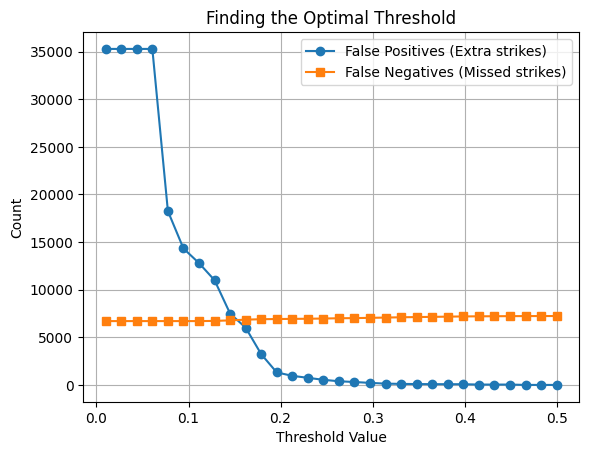

In [34]:
import matplotlib.pyplot as plt

# 1. Get a sample from your validation set
images, density_targets, ids = next(iter(val_loader))
sample_idx = 0
true_density = density_targets[sample_idx].numpy()
# Get ground truth coordinates (N, 3) from the density map itself for consistency
y_true = density_to_lightning_table(true_density, threshold=0.5)

# Get model prediction
loaded_model.eval()
with torch.no_grad():
    pred_density = loaded_model(images.to(device))[sample_idx].cpu().numpy()

# 2. Sweep through thresholds
thresholds = np.linspace(0.01, 0.5, 30)
results = []

for thresh in thresholds:
    y_pred = density_to_lightning_table(pred_density, threshold=thresh)
    tp, fp, fn = evaluate_threshold_flexible(y_true, y_pred)
    results.append({'threshold': thresh, 'TP': tp, 'FP': fp, 'FN': fn})

# 3. Print the table to see the trade-off
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)

# 4. Plot to find the "Sweet Spot"
plt.plot(df_results['threshold'], df_results['FP'], label='False Positives (Extra strikes)', marker='o')
plt.plot(df_results['threshold'], df_results['FN'], label='False Negatives (Missed strikes)', marker='s')
plt.xlabel('Threshold Value')
plt.ylabel('Count')
plt.legend()
plt.title('Finding the Optimal Threshold')
plt.grid(True)
plt.show()

In [25]:
# Test coordinate extraction
model.eval()
with torch.no_grad():
    images, density_targets, ids = next(iter(test_loader))
    images = images.to(device)
    pred_density = model(images).cpu().numpy()

    # Extract coordinates from first sample
    pred_coords = density_to_lightning_table(pred_density[0], threshold=0.3, neighborhood_size=5)
    print(f"Extracted {len(pred_coords)} predicted lightning strikes")
    if len(pred_coords) > 0:
        print(f"Sample predictions (t, x, y):")
        print(pred_coords[:10])

Extracted 5221 predicted lightning strikes
Sample predictions (t, x, y):
[[  0   0   0]
 [  0   7   0]
 [  0  11   0]
 [  0  15   0]
 [  0  19   0]
 [  0  27   0]
 [  0  31   0]
 [  0 191   0]
 [  0  14   7]
 [  0  10   9]]


## Evaluation: Overlay Predictions on VIL Images

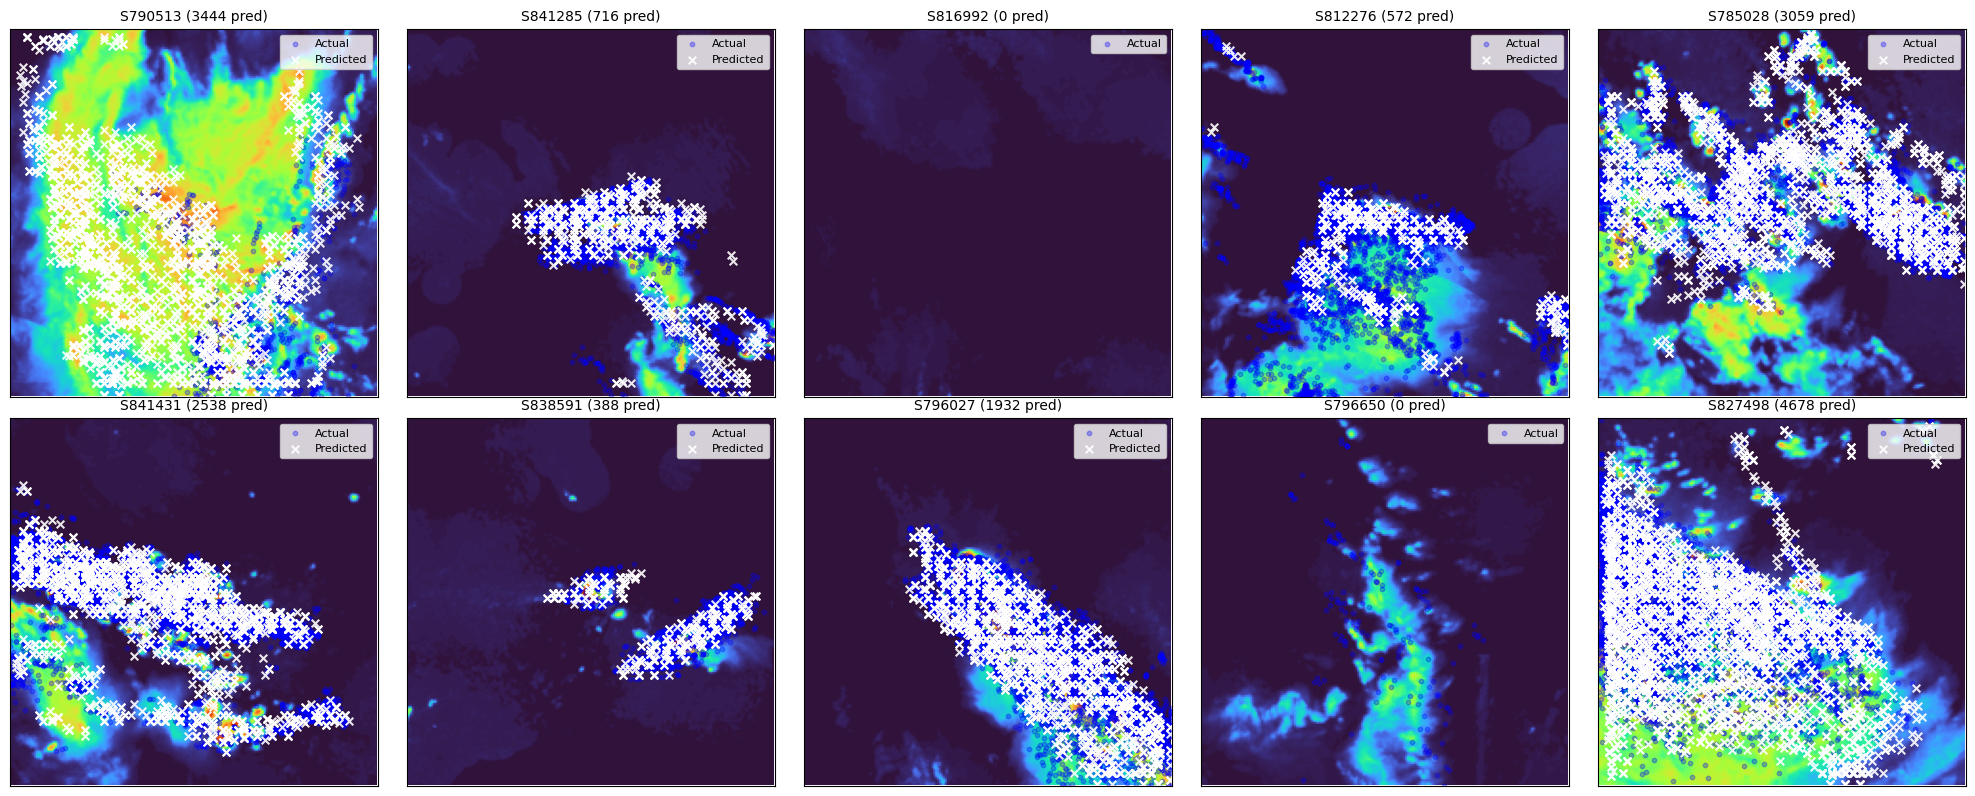

In [ ]:
def visualize_predictions_on_vil(model, test_loader, device, threshold=0.3):
    """Visualize extracted predictions overlaid on VIL images."""
    model.eval()

    # Collect all test samples
    all_samples = []
    with torch.no_grad():
        for images, density_targets, ids in test_loader:
            images_device = images.to(device)
            pred_density = model(images_device).cpu().numpy()

            for i in range(len(ids)):
                pred_coords = density_to_coordinates(pred_density[i], threshold=threshold)
                all_samples.append({
                    'id': ids[i],
                    'pred_coords': pred_coords,
                    'pred_density': pred_density[i],
                    'gt_density': density_targets[i].numpy()
                })

    # Plot in 2x5 grids
    for start_idx in range(0, min(10, len(all_samples)), 10):
        batch = all_samples[start_idx:start_idx + 10]
        n_samples = len(batch)
        n_cols = 5
        n_rows = (n_samples + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
        axes = axes.flatten() if n_samples > 1 else [axes]

        for idx, sample in enumerate(batch):
            ax = axes[idx]
            event = load_event(sample['id'])
            pred_coords = sample['pred_coords']

            # Use middle frame
            frame_idx = 17

            # Display VIL image (resize to 192x192 to match coordinate system)
            vil_frame = np.array(Image.fromarray(event['vil'][:, :, frame_idx]).resize((192, 192), Image.BILINEAR))
            ax.imshow(vil_frame, vmin=0, vmax=255, cmap='turbo')

            # Overlay actual lightning locations (blue circles)
            actual_x = event['lght'][:, 3] / 2.0
            actual_y = event['lght'][:, 4] / 2.0
            ax.scatter(actual_x, actual_y, marker='o', s=10, c='blue', alpha=0.3, label='Actual')

            # Overlay predicted lightning locations (white x markers)
            if len(pred_coords) > 0:
                ax.scatter(pred_coords[:, 1], pred_coords[:, 2],
                          marker='x', s=30, c='white', linewidths=1.5, alpha=0.9, label='Predicted')

            ax.set_xlim(0, 192)
            ax.set_ylim(192, 0)
            ax.set_title(f'{sample["id"]} ({len(pred_coords)} pred)', fontsize=10)
            ax.legend(loc='upper right', fontsize=8)
            ax.set_xticks([])
            ax.set_yticks([])

        # Hide unused subplots
        for idx in range(n_samples, len(axes)):
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

visualize_predictions_on_vil(model, test_loader, device, threshold=0.3)

#Save model

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Define the path inside Drive
model_save_path = "/content/drive/MyDrive/densitymap_predictor.pth"

# Save the model
import torch
torch.save(model.state_dict(), model_save_path)

print(f"Model permanently saved to {model_save_path}")

Model permanently saved to /content/drive/MyDrive/densitymap_predictor.pth


In [30]:
# Initialize a new model instance
loaded_model = DensityMapPredictor(input_channels=4, num_frames=36).to(device)

# 3. Load the weights from Drive
model_save_path = "/content/drive/MyDrive/densitymap_predictor.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Add map_location to the torch.load command
state_dict = torch.load(model_save_path, map_location=device)
loaded_model.load_state_dict(state_dict)

# 4. Set to evaluation mode
# This is crucial for plotting/inference (it disables dropout/batchnorm)
loaded_model.eval()

print(f"Model loaded from {model_save_path}")

Model loaded from /content/drive/MyDrive/densitymap_predictor.pth


#Save outputs to a table

In [18]:
import os
import torch
import numpy as np
from tqdm import tqdm

def save_all_predictions(model, dataloader, device, save_dir="predictions", threshold=0.45):
    """
    Runs the model on all data and saves (N, 3) coordinate tables.
    """
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    with torch.no_grad():
        for images, _, ids in tqdm(dataloader, desc="Generating Prediction Tables"):
            images = images.to(device)
            # Predict density maps
            preds = model(images).cpu().numpy() # (B, 36, 192, 192)

            for i, event_id in enumerate(ids):
                # Convert density maps to [time_idx, x, y]
                # Using the function we discussed earlier
                coords = density_to_lightning_table(preds[i], threshold=threshold)

                # Save as .npy for fast loading later
                np.save(os.path.join(save_dir, f"{event_id}_pred.npy"), coords)

In [35]:
# Create a specific folder in your Drive
drive_save_path = "/content/drive/MyDrive/lightning_predictions"

# Call the function with this path
save_all_predictions(loaded_model, test_loader, device, save_dir=drive_save_path)

Generating Prediction Tables: 100%|██████████| 4/4 [00:12<00:00,  3.01s/it]


In [45]:
# test
import numpy as np

# Load the file
data = np.load('/content/drive/MyDrive/lightning_predictions/S790513_pred.npy')

# View the contents
print(data)

[[  0   0   0]
 [  0  14   7]
 [  0  14  11]
 ...
 [ 35 137 185]
 [ 35 141 185]
 [ 35 135 191]]


## Compute IoU and Pixel-Level Metrics

In [ ]:
def compute_iou(pred, target, threshold=0.5):
    """Compute Intersection over Union between predicted and target density maps."""
    pred_binary = (pred > threshold).astype(np.float32)
    target_binary = (target > threshold).astype(np.float32)

    intersection = np.sum(pred_binary * target_binary)
    union = np.sum(pred_binary) + np.sum(target_binary) - intersection

    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    return intersection / union


def evaluate_model(model, test_loader, device, threshold=0.5):
    """Compute evaluation metrics on test set."""
    model.eval()

    all_ious = []
    total_loss = 0.0

    with torch.no_grad():
        for images, density_targets, ids in test_loader:
            images = images.to(device)
            density_targets_device = density_targets.to(device)

            pred_density = model(images)
            loss = focal_loss(pred_density, density_targets_device)
            total_loss += loss.item()

            pred_np = pred_density.cpu().numpy()
            target_np = density_targets.numpy()

            for i in range(len(ids)):
                iou = compute_iou(pred_np[i], target_np[i], threshold)
                all_ious.append(iou)

    avg_loss = total_loss / len(test_loader)
    avg_iou = np.mean(all_ious)

    print(f"Test Results:")
    print(f"  Average Focal Loss: {avg_loss:.6f}")
    print(f"  Average IoU (threshold={threshold}): {avg_iou:.4f}")
    print(f"  Number of samples: {len(all_ious)}")

    return avg_loss, avg_iou

evaluate_model(model, test_loader, device)

Test Results:
  Average Focal Loss: 0.007223
  Average IoU (threshold=0.5): 0.3630
  Number of samples: 16


(0.007223403546959162, np.float64(0.36295050173066556))

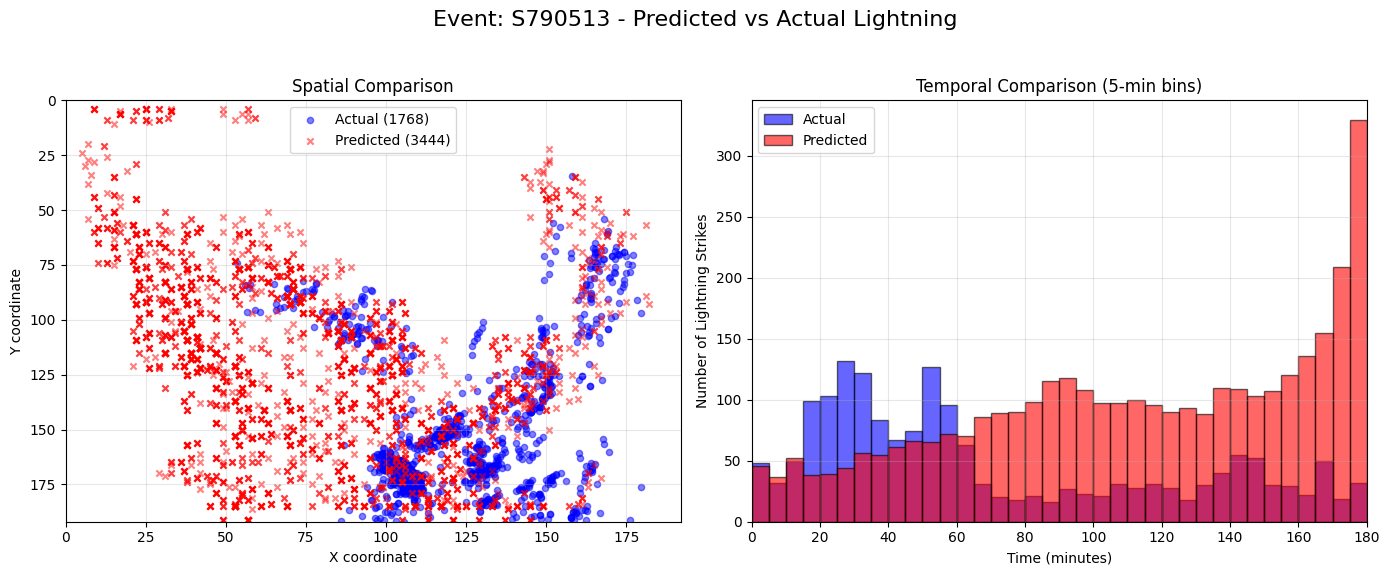

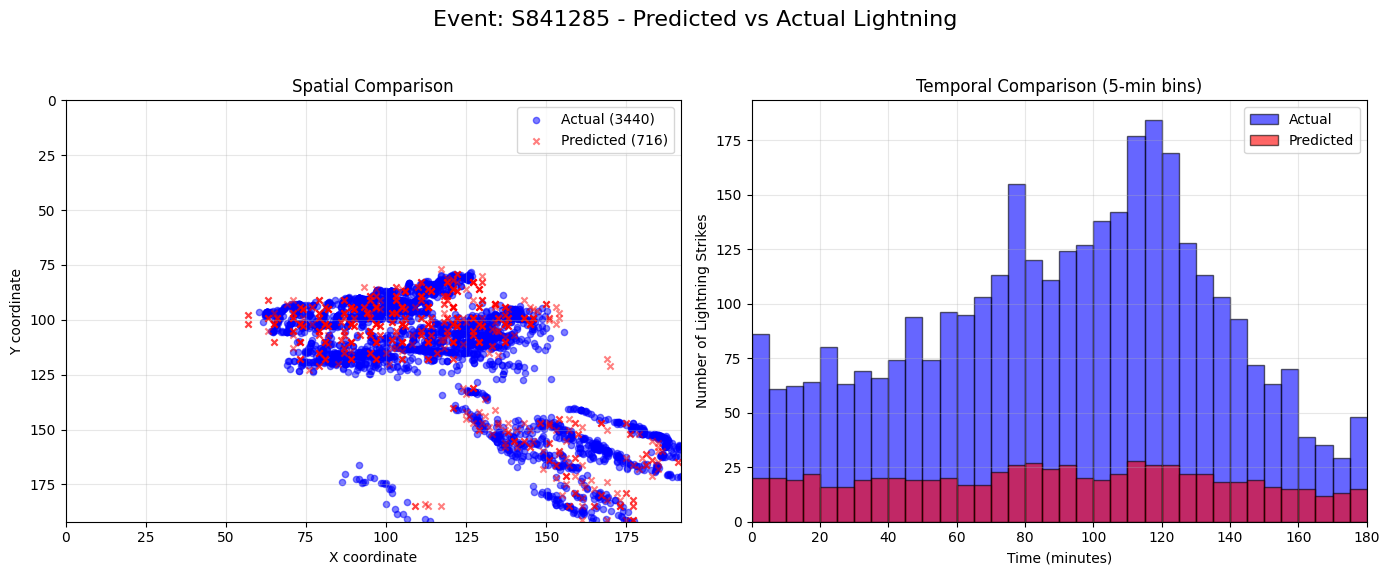

/tmp/ipython-input-2416533591.py:54: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
/tmp/ipython-input-2416533591.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


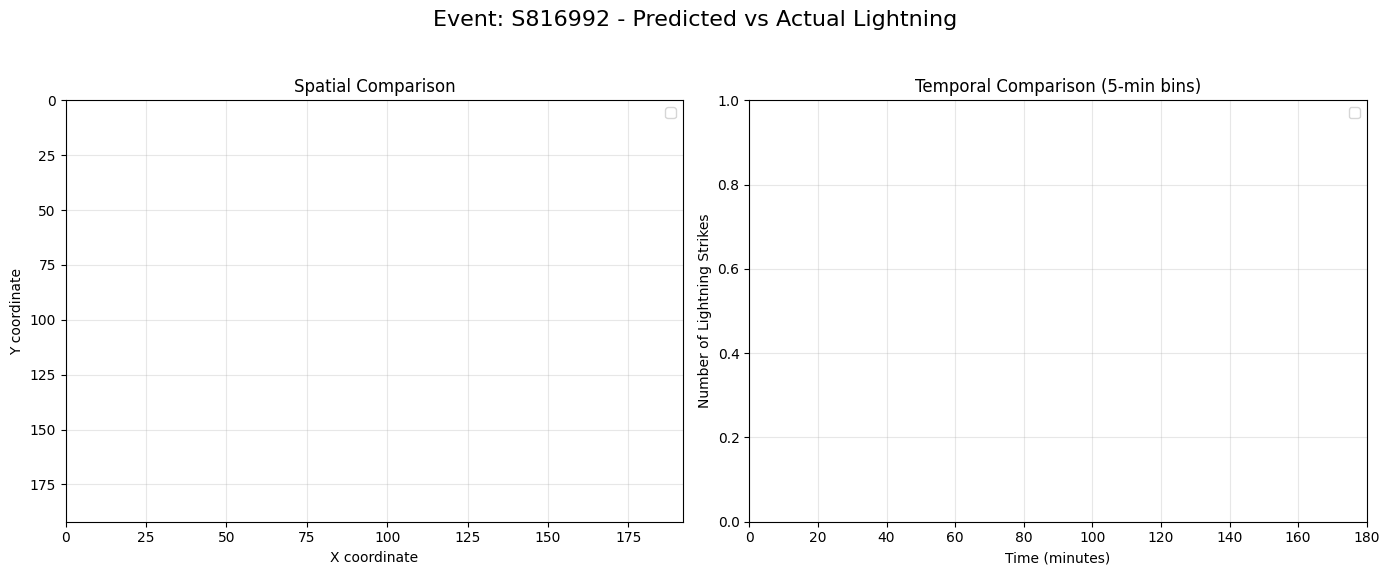

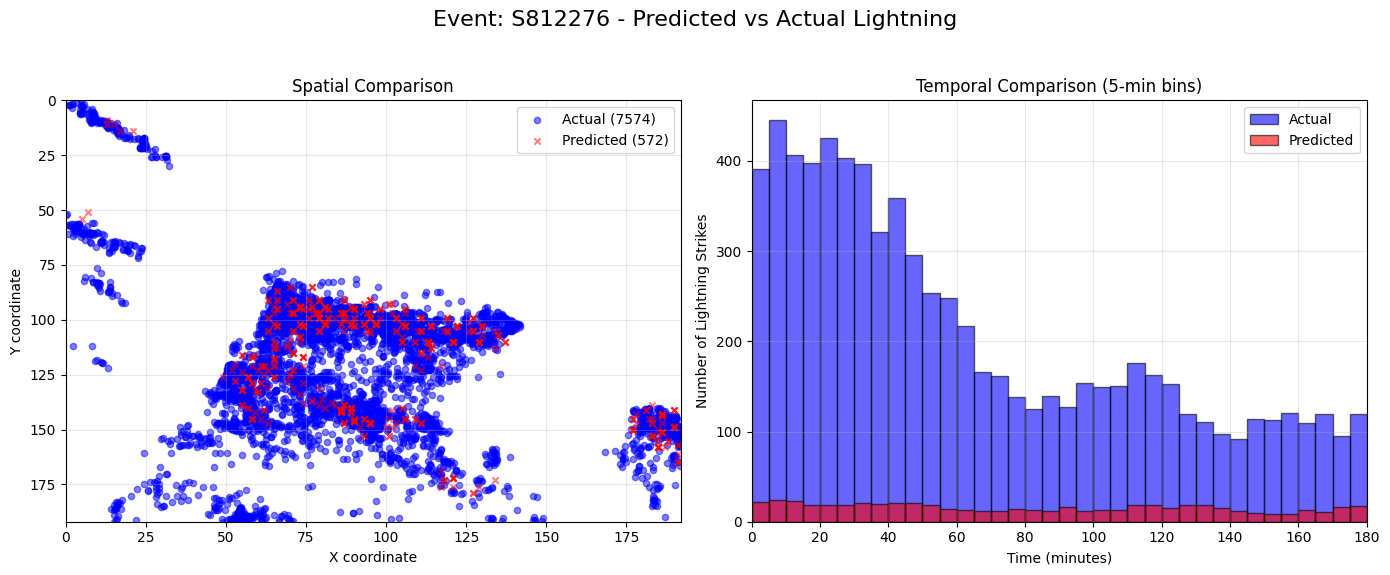

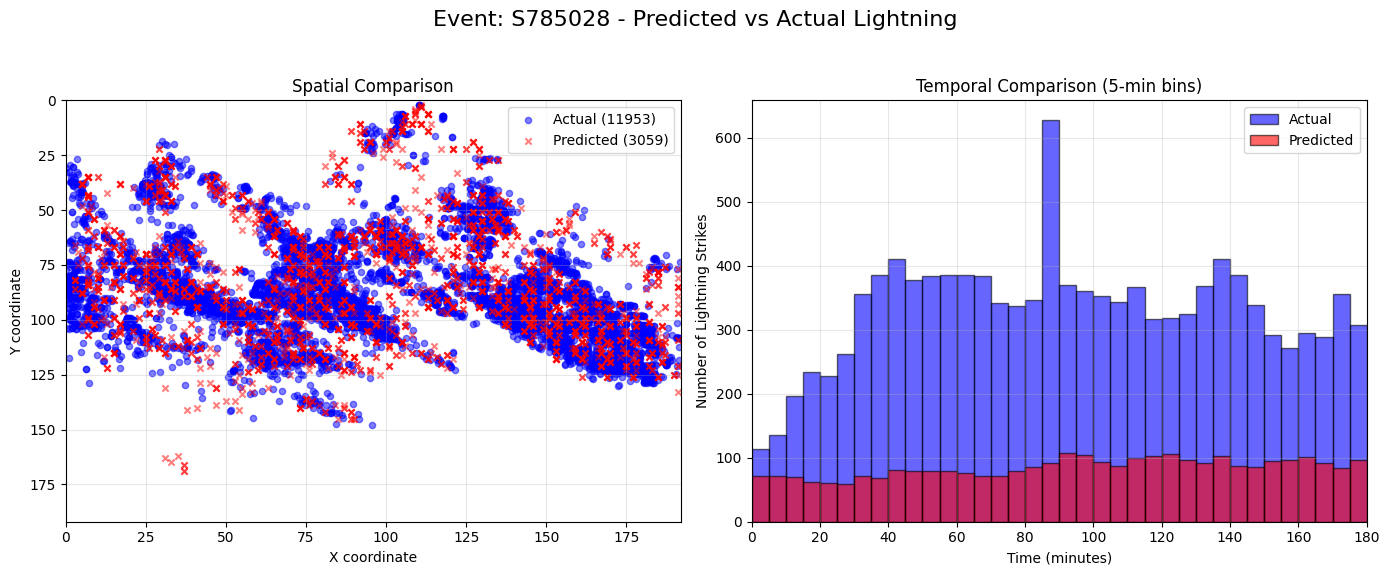

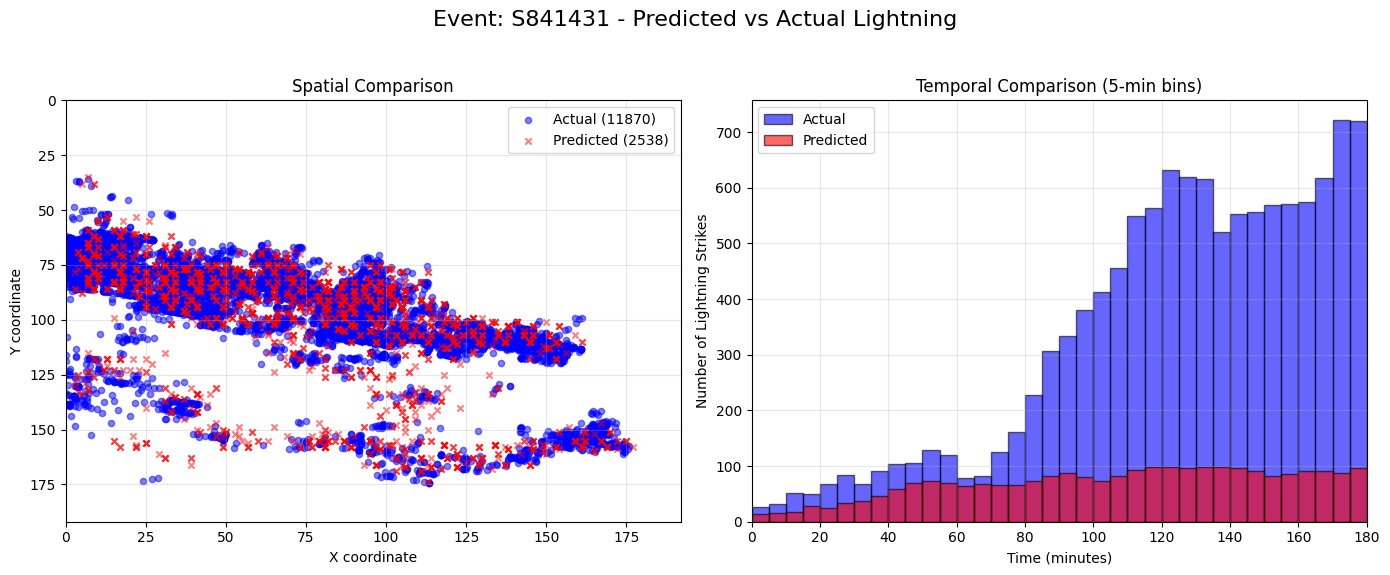

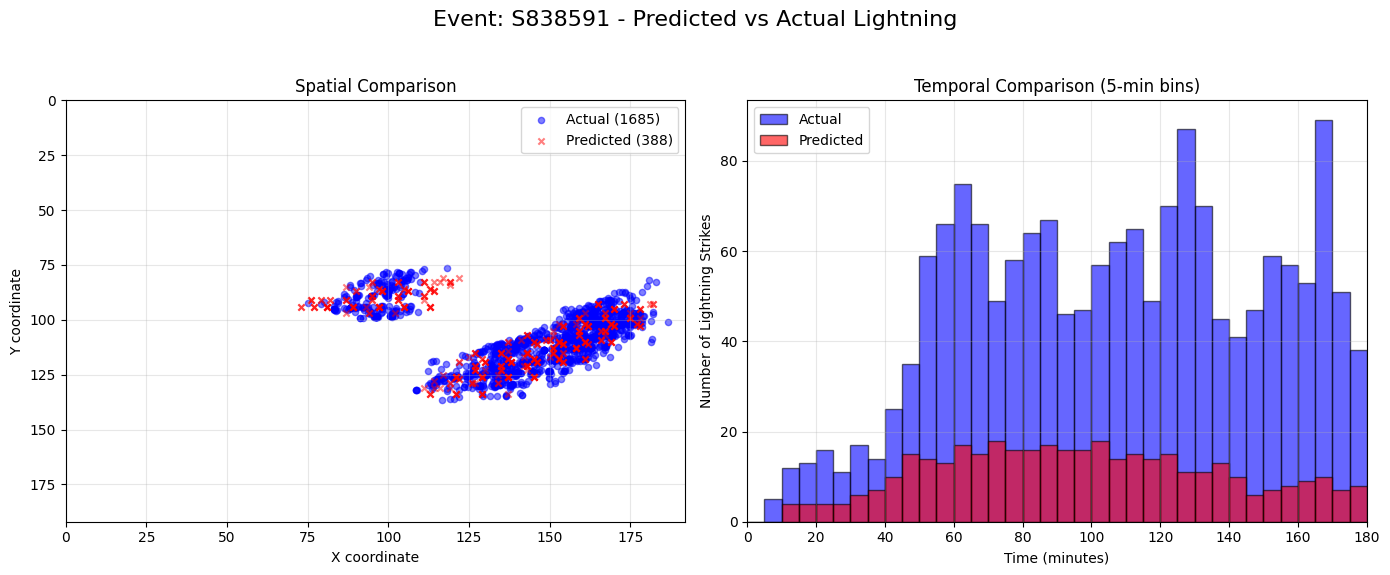

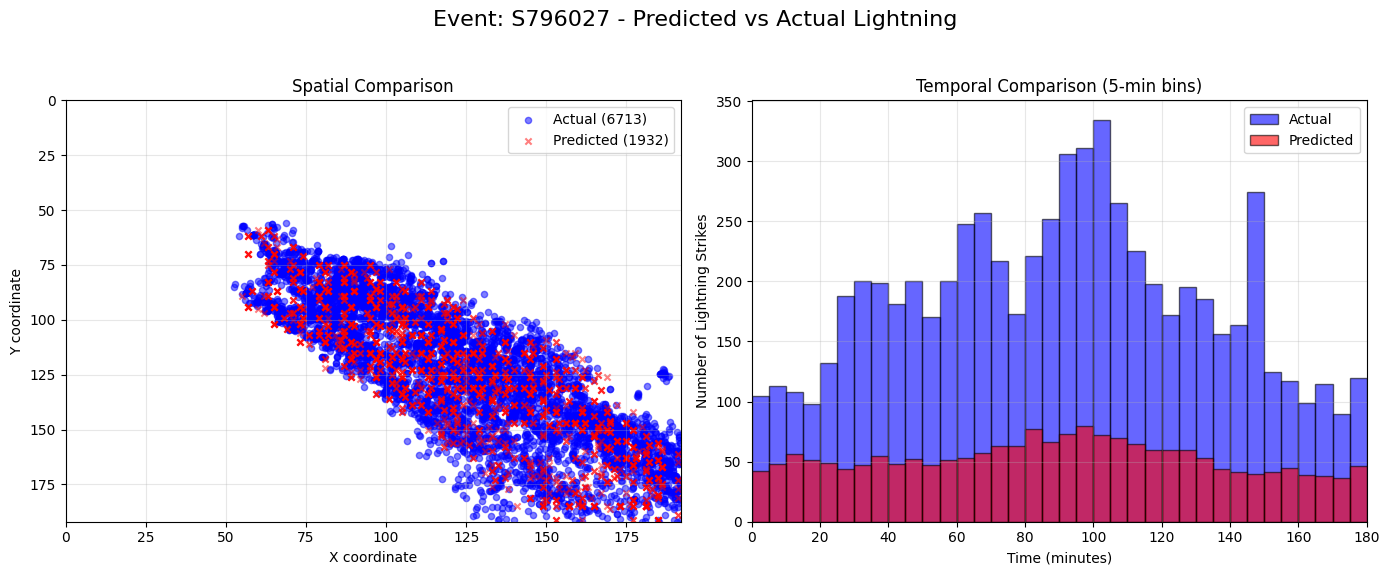

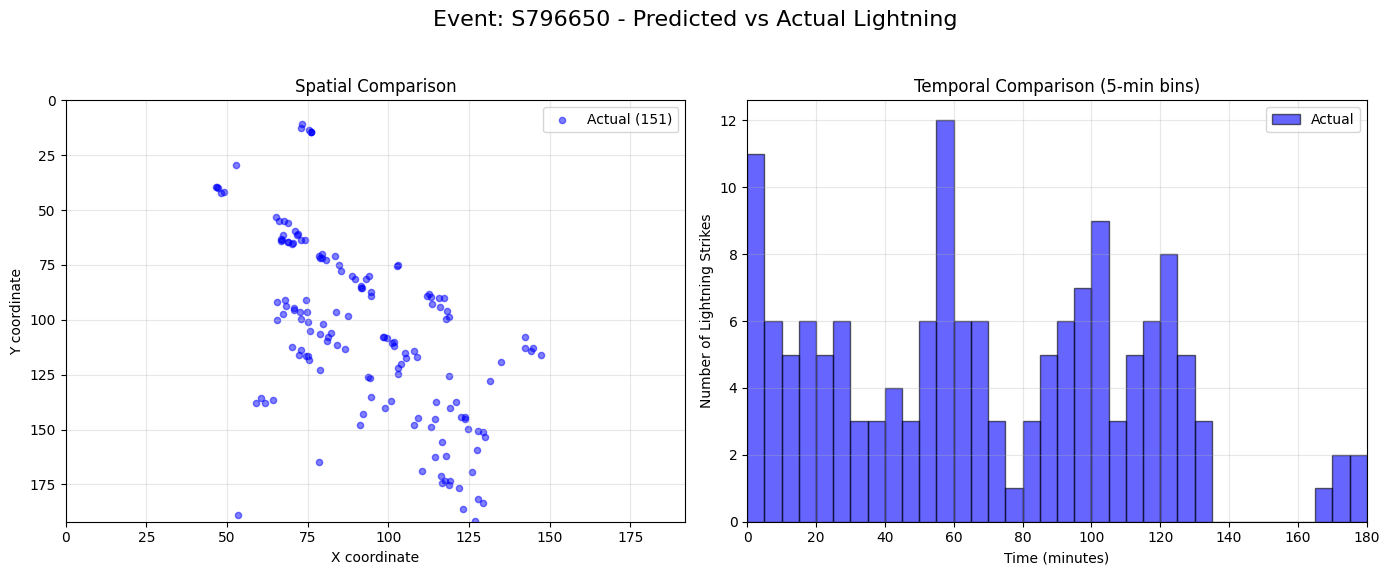

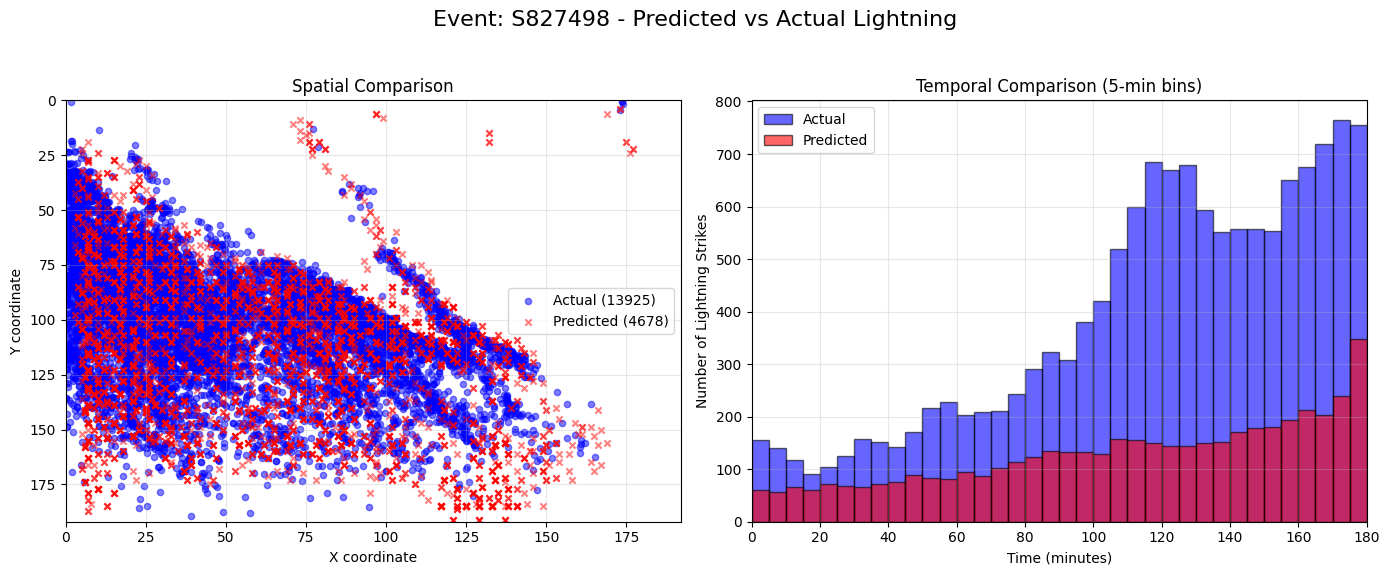

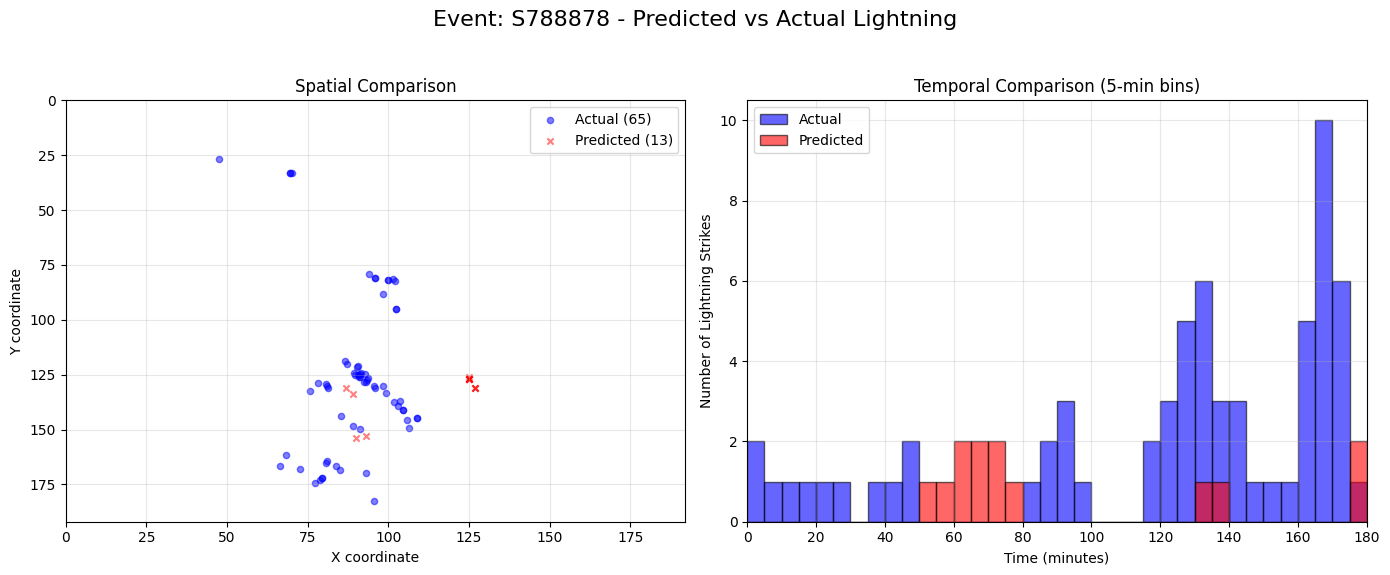

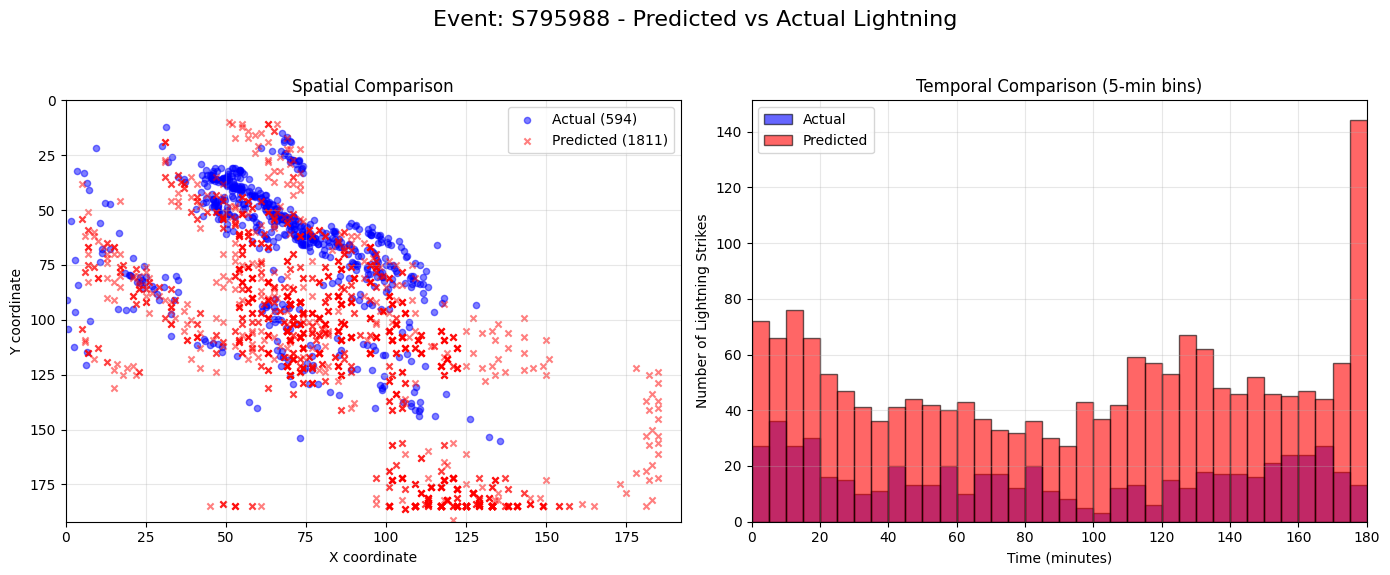

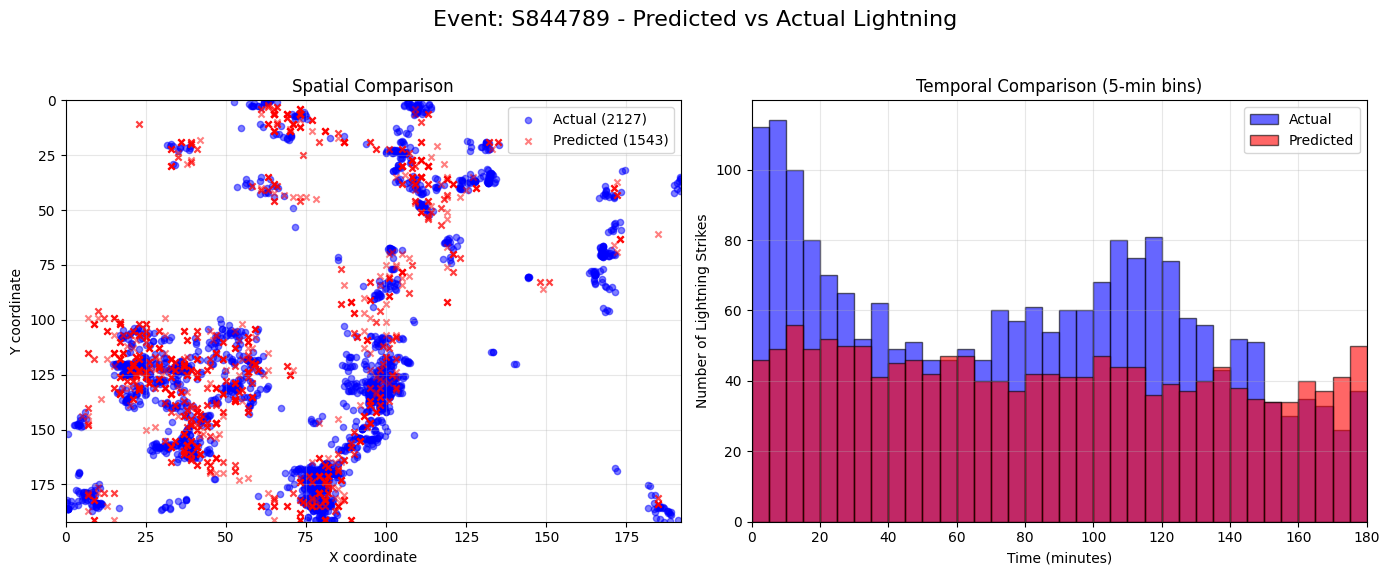

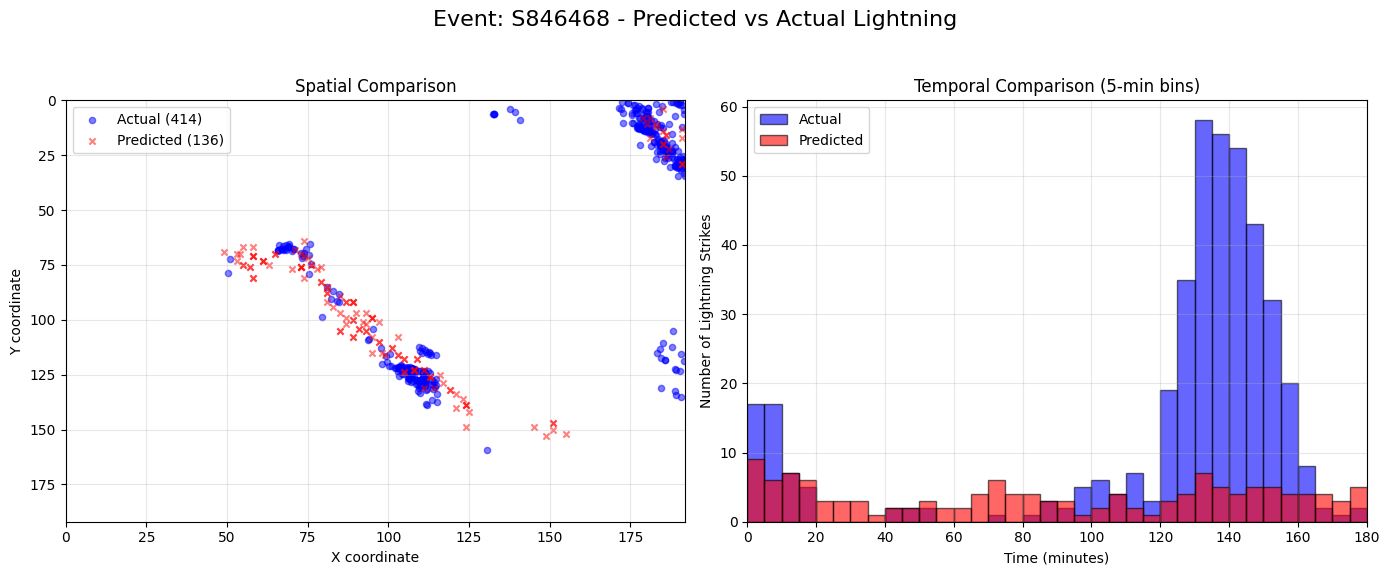

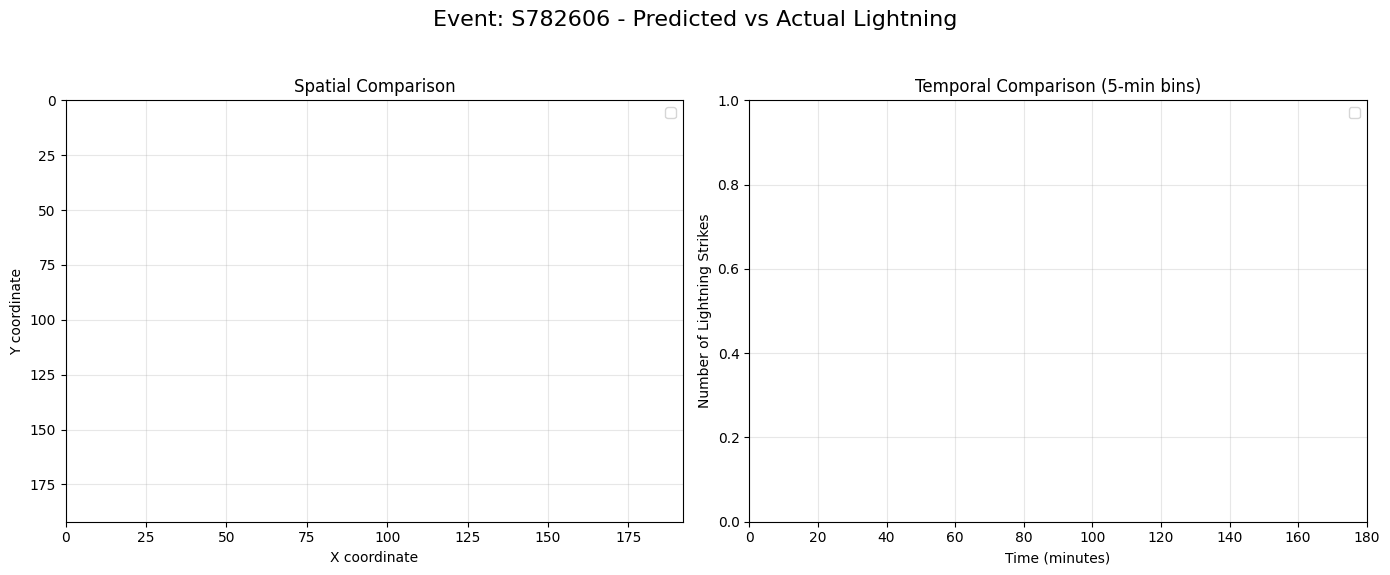

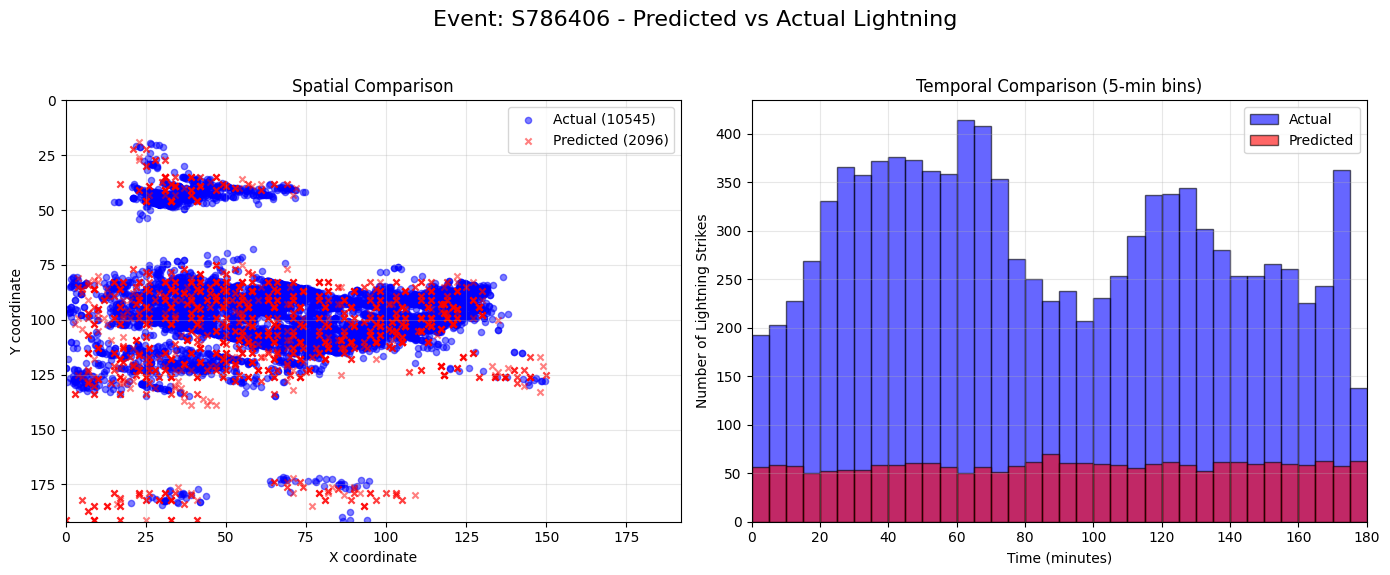

In [ ]:
def compare_predictions_full_timespan(model, test_loader, device, num_samples_to_plot=3, threshold=0.3, min_distance=5):
    """
    Visualizes and compares predicted vs actual lightning events spatially and temporally
    across the full timespan for a selection of test samples.
    """
    model.eval()
    samples_plotted = 0

    with torch.no_grad():
        for images, density_targets, ids in test_loader:
            if samples_plotted >= num_samples_to_plot:
                break

            images_device = images.to(device)
            pred_density = model(images_device).cpu().numpy()

            for i in range(len(ids)):
                if samples_plotted >= num_samples_to_plot:
                    break

                event_id = ids[i]

                # Get predicted coordinates from density map
                current_pred_density = pred_density[i] # (T, H, W)
                pred_coords = density_to_coordinates(current_pred_density, threshold=threshold, min_distance=min_distance)

                # Load actual event to get true lightning coordinates
                event_data = load_event(event_id)
                actual_lght = event_data['lght'] # (N, 5) -> (t_sec, z, y_orig, x_orig, ??)

                # Scale actual coordinates to 192x192 resolution
                actual_coords = np.stack([
                    actual_lght[:, 0],           # time in seconds
                    actual_lght[:, 3] / 2.0,     # x scaled to 192
                    actual_lght[:, 4] / 2.0      # y scaled to 192
                ], axis=1).astype(np.float32)

                fig, axes = plt.subplots(1, 2, figsize=(14, 6))
                fig.suptitle(f'Event: {event_id} - Predicted vs Actual Lightning', fontsize=16)

                # --- Spatial Comparison (Scatter Plot of X, Y coordinates) ---
                if len(actual_coords) > 0:
                    axes[0].scatter(actual_coords[:, 1], actual_coords[:, 2],
                                    alpha=0.5, label=f'Actual ({len(actual_coords)})', c='blue', s=20)
                if len(pred_coords) > 0:
                    axes[0].scatter(pred_coords[:, 1], pred_coords[:, 2],
                                    alpha=0.5, label=f'Predicted ({len(pred_coords)})', c='red', s=20, marker='x')

                axes[0].set_xlabel('X coordinate')
                axes[0].set_ylabel('Y coordinate')
                axes[0].set_title('Spatial Comparison')
                axes[0].set_xlim(0, 192)
                axes[0].set_ylim(192, 0) # Flip y-axis to match image coordinates convention
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)

                # --- Temporal Comparison (Histograms of Time) ---
                bins = np.arange(0, 36 * 5 + 1, 5) # 0 to 180 minutes, 5-min intervals

                if len(actual_coords) > 0:
                    axes[1].hist(actual_coords[:, 0] / 60.0, bins=bins, alpha=0.6, label='Actual', color='blue', edgecolor='black')
                if len(pred_coords) > 0:
                    axes[1].hist(pred_coords[:, 0] / 60.0, bins=bins, alpha=0.6, label='Predicted', color='red', edgecolor='black')

                axes[1].set_xlabel('Time (minutes)')
                axes[1].set_ylabel('Number of Lightning Strikes')
                axes[1].set_title('Temporal Comparison (5-min bins)')
                axes[1].set_xlim(0, 180) # 36 frames * 5 minutes/frame
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
                samples_plotted += 1

# Call the function to visualize for a few test samples
compare_predictions_full_timespan(loaded_model, test_loader, device, num_samples_to_plot=16)

In [ ]:
# Select a random event ID from the test set for demonstration
sample_event_id = test_dataset.event_ids[0]  # Get ID from the first event in test_dataset

# Load the lightning data for this event
sample_event_data = load_event(sample_event_id)
actual_lght = sample_event_data['lght']

# Scale actual coordinates to 192x192 resolution and convert time to minutes
lightning_strikes_table = pd.DataFrame({
    'time_minutes': actual_lght[:, 0] / 60.0,
    'x_coord_192': actual_lght[:, 3] / 2.0,
    'y_coord_192': actual_lght[:, 4] / 2.0
})

print(f"Lightning strikes for event ID: {sample_event_id}")
display(lightning_strikes_table.head())

In [ ]:
# Select a sample from the test loader
# We'll use the first event from the first batch for demonstration
images, _, ids = next(iter(test_loader))

# Get the first sample's data
sample_image = images[0:1].to(device) # Keep batch dimension for model input
sample_id = ids[0]

# Get the model's prediction
loaded_model.eval()
with torch.no_grad():
    predicted_density_map = loaded_model(sample_image).cpu().numpy()[0] # (T, H, W)

# Convert predicted density map to coordinates
predicted_coords = density_to_coordinates(predicted_density_map, threshold=0.3)

# Create a DataFrame for predicted lightning strikes
if len(predicted_coords) > 0:
    predicted_lightning_table = pd.DataFrame({
        'time_minutes': predicted_coords[:, 0] / 60.0,
        'x_coord_192': predicted_coords[:, 1],
        'y_coord_192': predicted_coords[:, 2]
    })
    print(f"Predicted lightning strikes for event ID: {sample_id}")
    display(predicted_lightning_table)
else:
    print(f"No predicted lightning strikes found for event ID: {sample_id} with the current threshold.")

Predicted lightning strikes for event ID: S790513


time_minutes  x_coord_192  y_coord_192
0              0.0            9            4
1              0.0           17            5
2              0.0           13            9
3              0.0            7           20
4              0.0           12           21
...            ...          ...          ...
3439         175.0          145          185
3440         175.0          149          185
3441         175.0          129          191
3442         175.0          137          191
3443         175.0          145          191

[3444 rows x 3 columns]